## 1 Import Libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os


# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configure plot display settings
# sns.set(font_scale=1.4)
# sns.set_style('white')
# plt.rc('font', size=14)
# %matplotlib inline

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## 2 Load Data

In [ ]:
# data loading
data = np.load("/kaggle/input/martemarte/mars_for_students.npz")
training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]
y_train=y_train.astype(np.int32)

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


Type and shapes of the data

In [ ]:
print(type(y_train))
y_train=y_train.astype(np.int32)

print(np.shape(y_train))
print(y_train[0,0,0])

# Define a mapping of labels to their corresponding digit names
classes = {0: 'Background', 1: 'Soil', 2: 'Bedrock', 3: 'Sand', 4: 'Big Rock'}
print(classes)

nomi_labels=list(classes.values())
print(nomi_labels)

<class 'numpy.ndarray'>
(2615, 64, 128)
2
{0: 'Background', 1: 'Soil', 2: 'Bedrock', 3: 'Sand', 4: 'Big Rock'}
['Background', 'Soil', 'Bedrock', 'Sand', 'Big Rock']


## 3 Data Inspection

### 3.1 PCA

Percentage of variance explained by the principal components: [0.59952449 0.06193483]


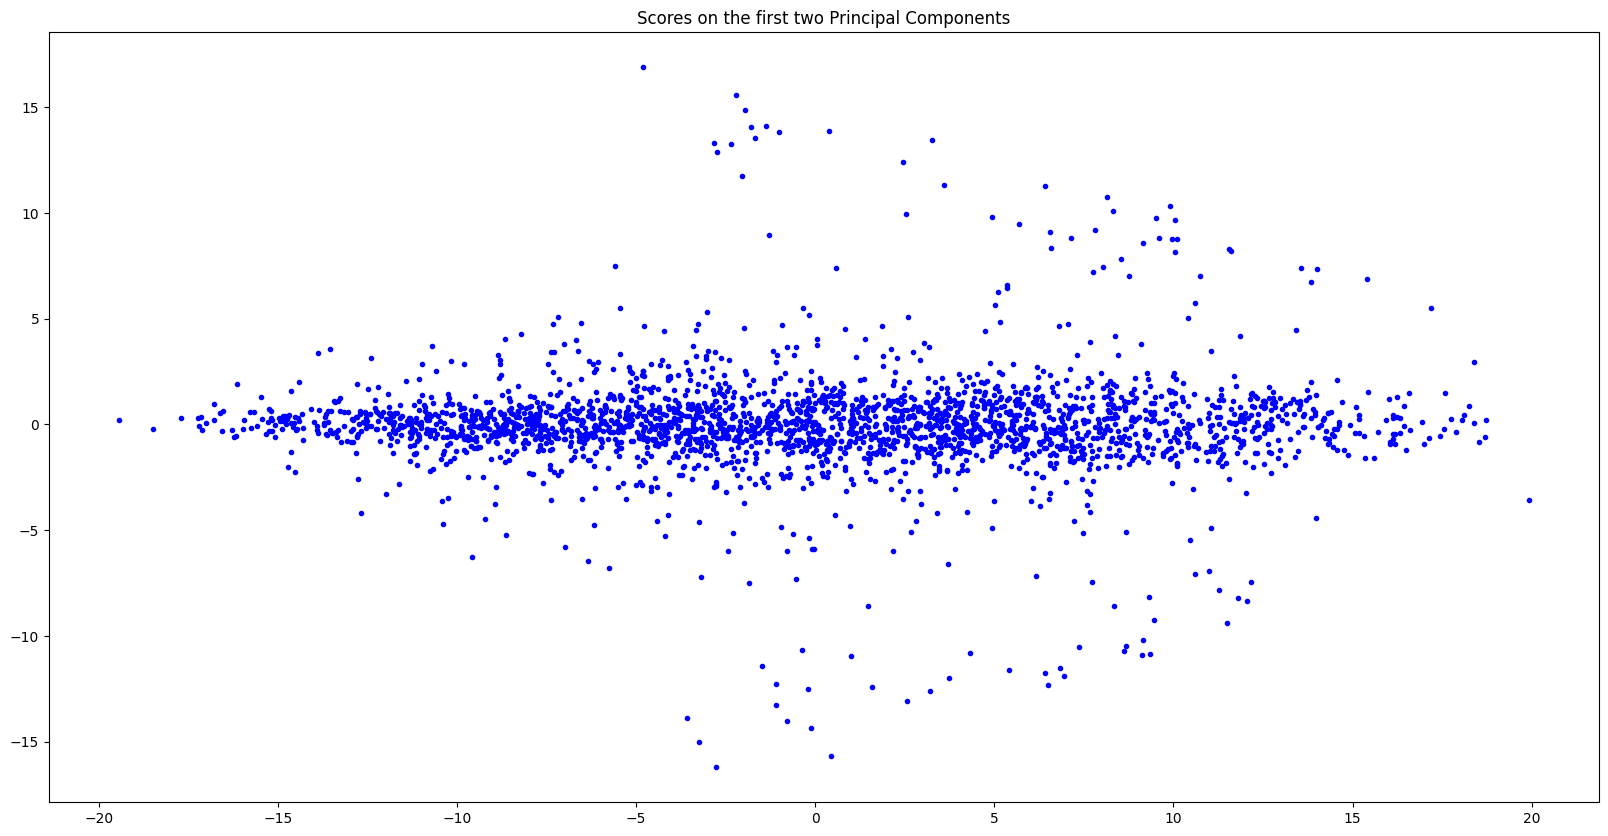

In [ ]:
# PCA analysis
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.manifold import TSNE
if np.max(X_train) > 1:
    X_train = X_train/255
images_flat = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))

# Apply PCA
pca = PCA(n_components=2)
pca.fit(images_flat)
print("Percentage of variance explained by the principal components:",pca.explained_variance_ratio_)
scores = pca.transform(images_flat)

# Plot
plt.figure(figsize=[20,10])
plt.title('Scores on the first two Principal Components')
plt.plot(scores[:,0],scores[:,1], 'b.')
plt.show()

### 3.2 Mahalanobis Distance

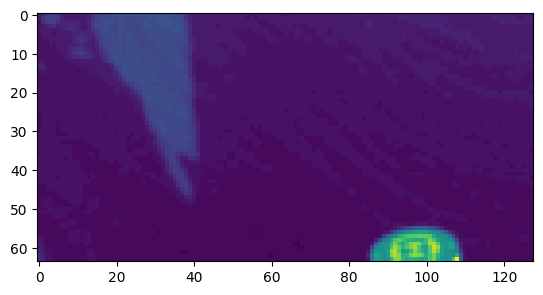

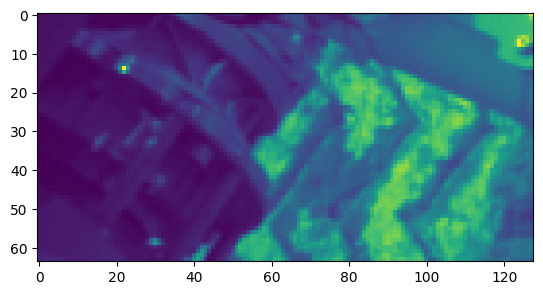

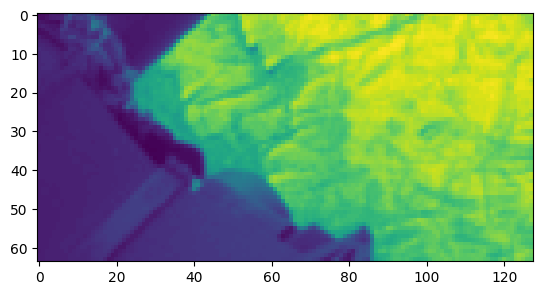

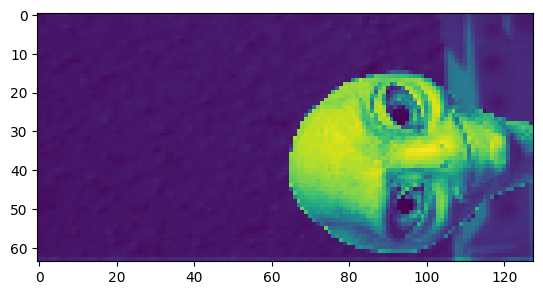

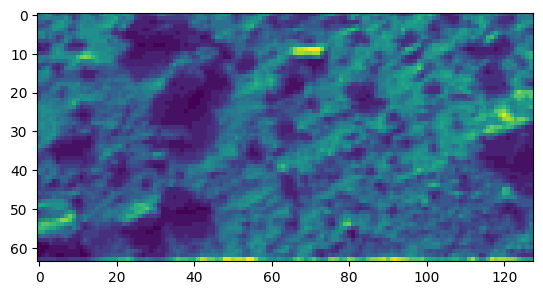

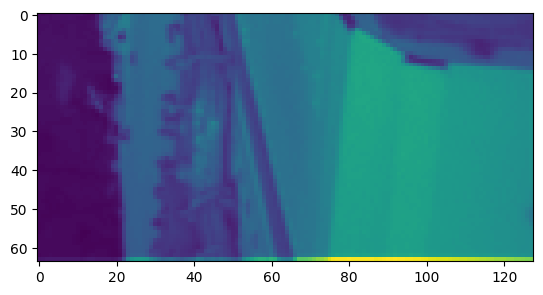

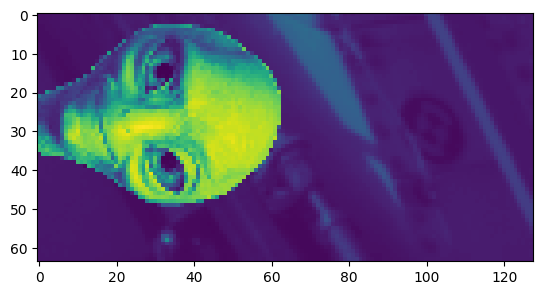

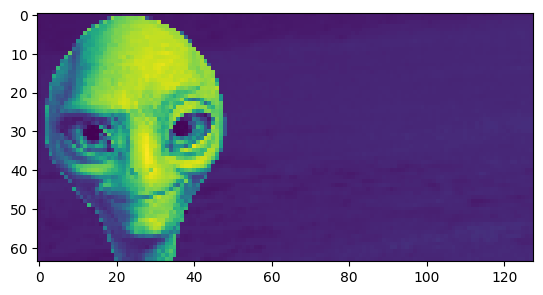

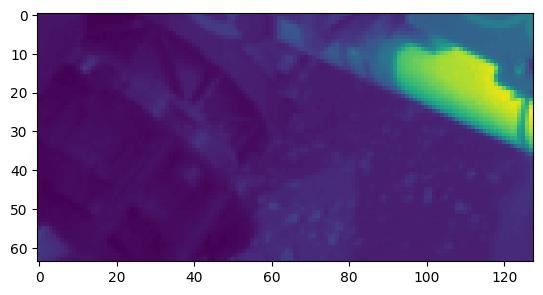

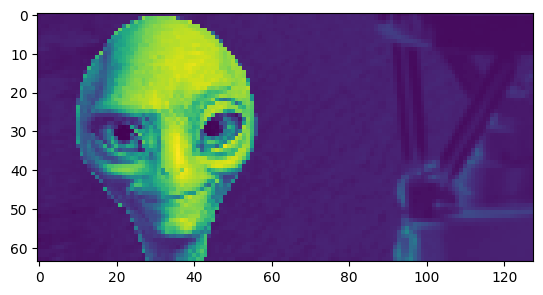

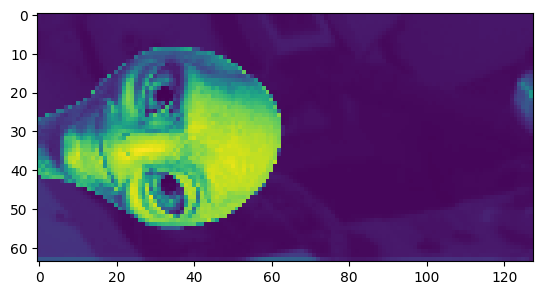

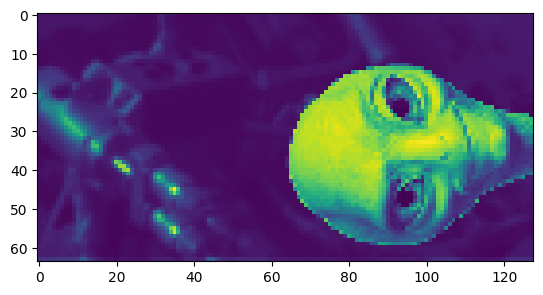

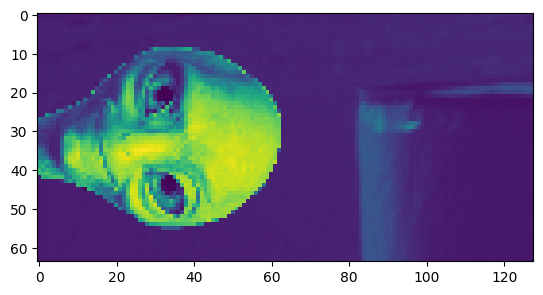

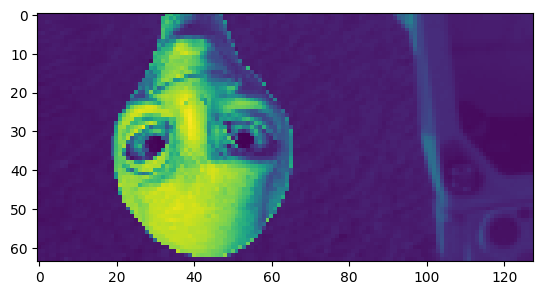

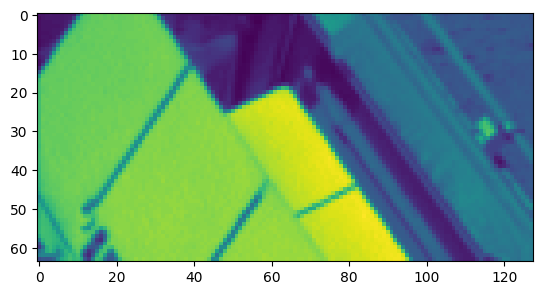

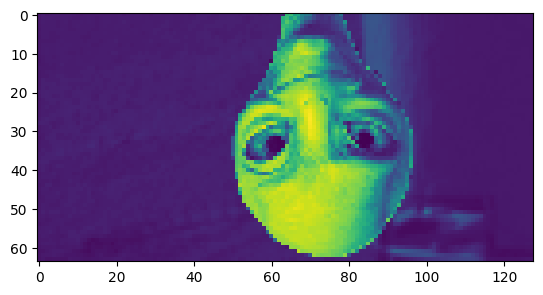

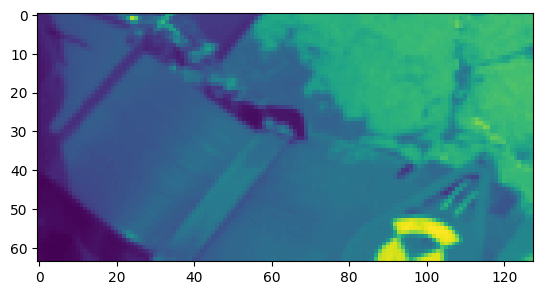

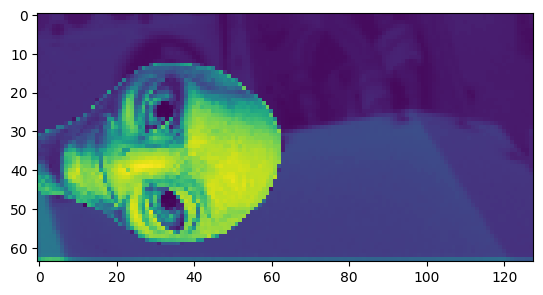

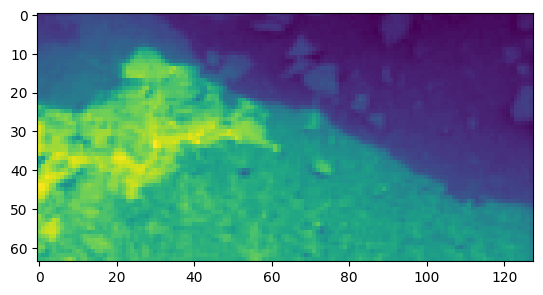

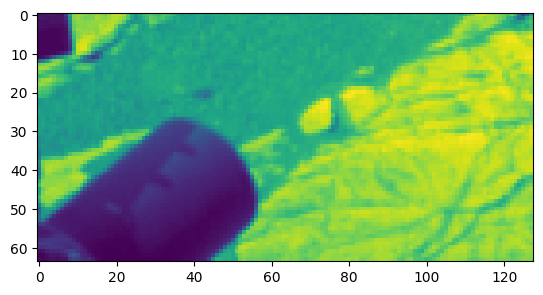

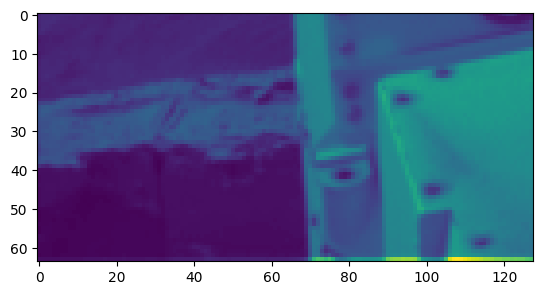

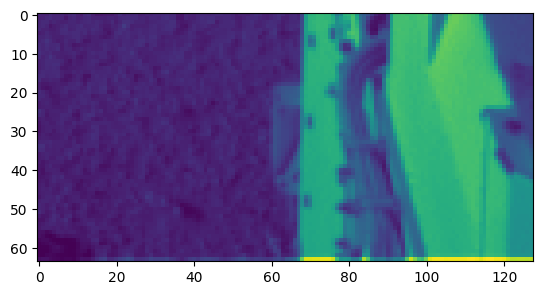

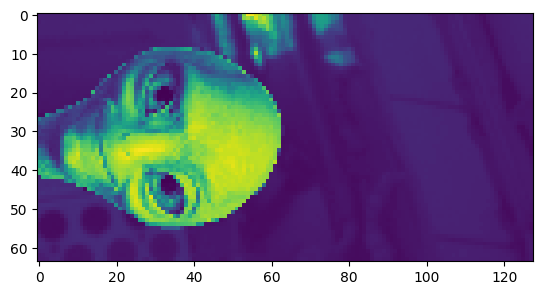

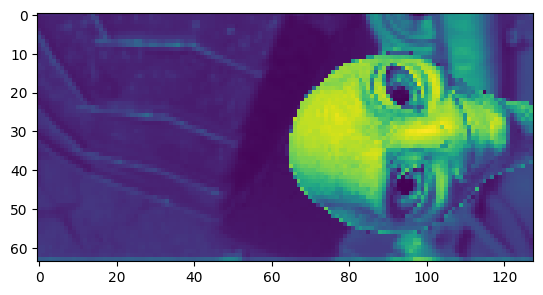

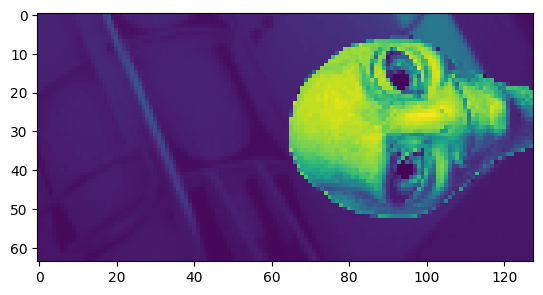

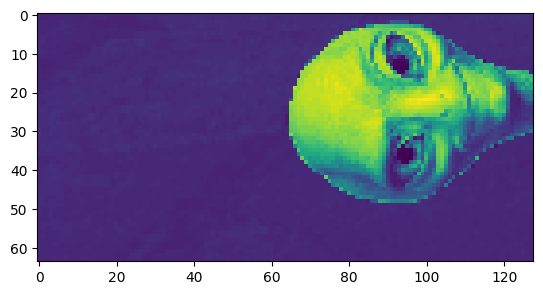

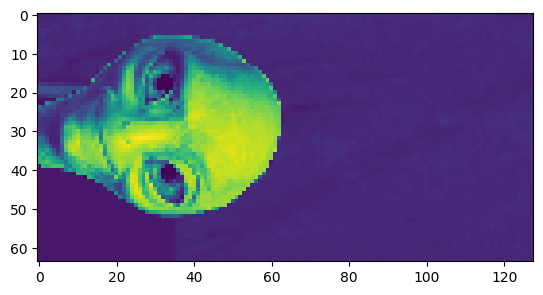

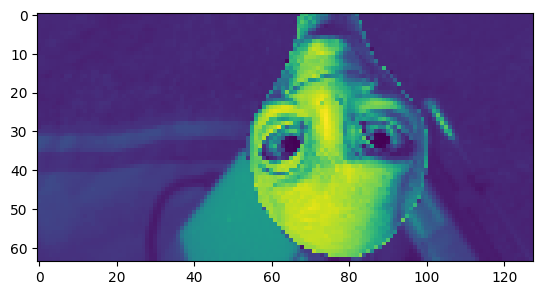

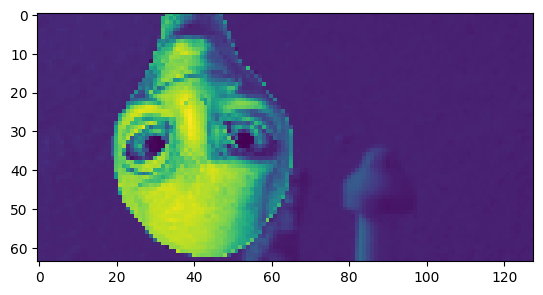

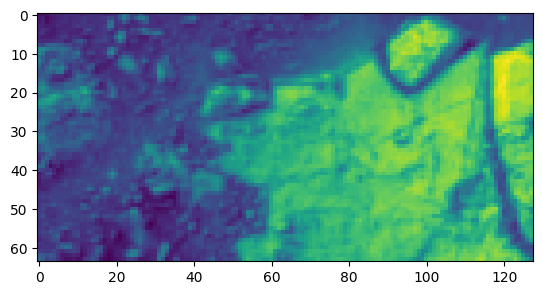

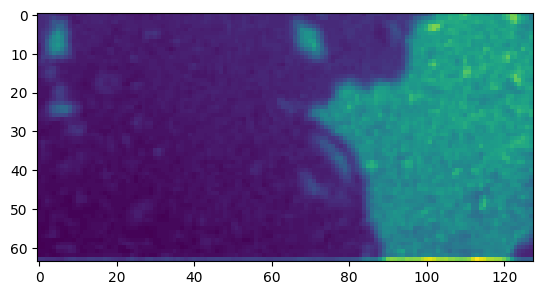

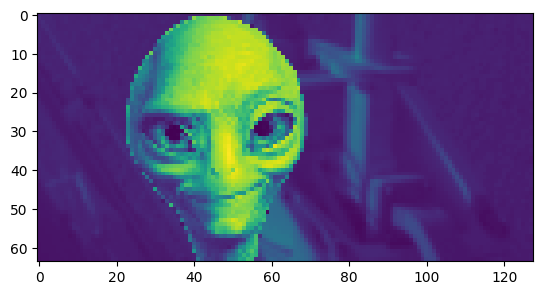

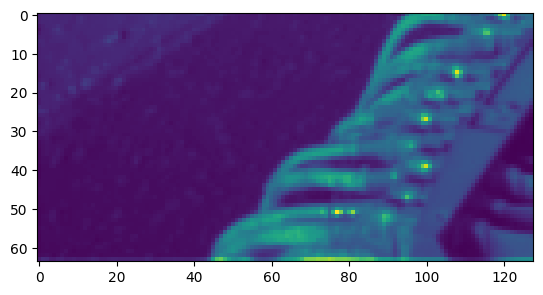

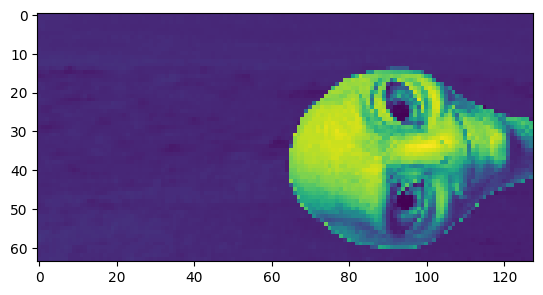

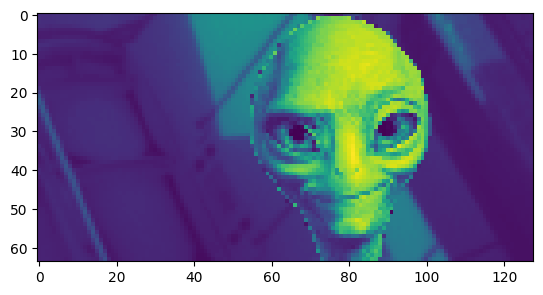

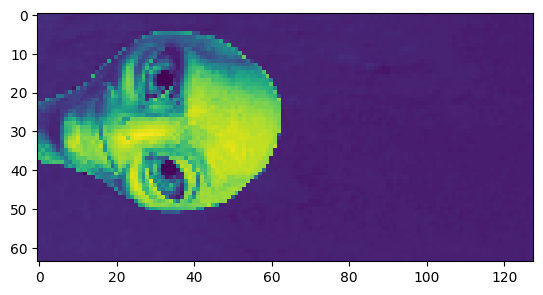

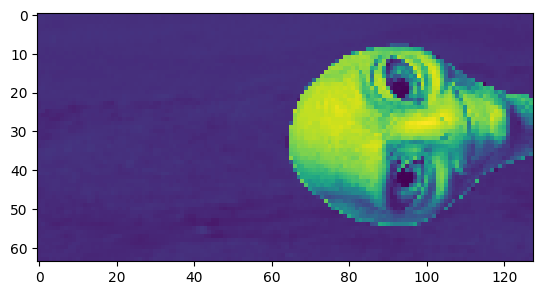

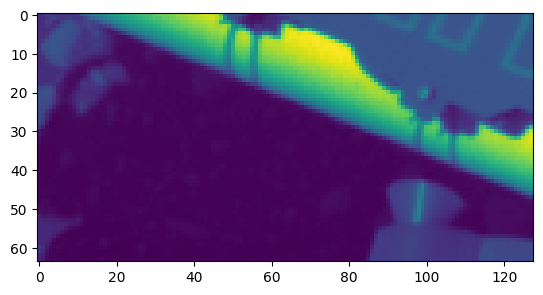

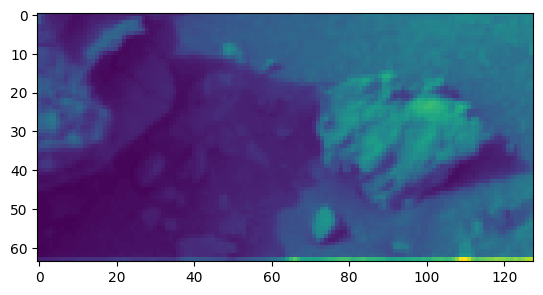

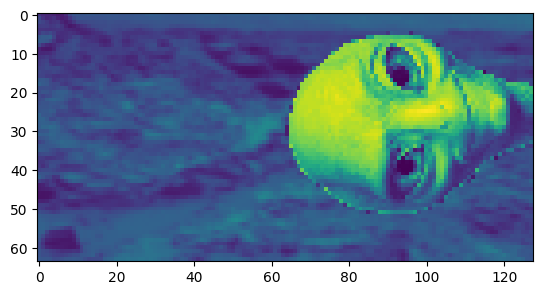

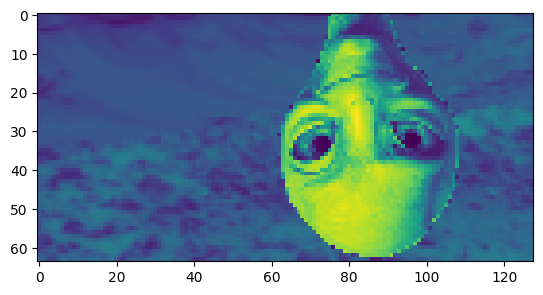

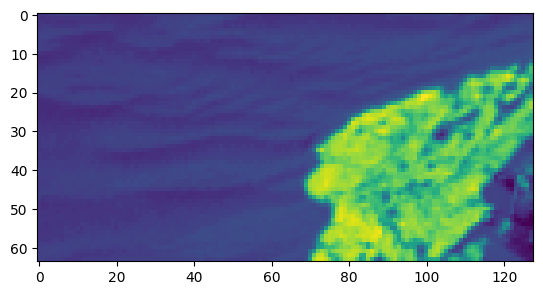

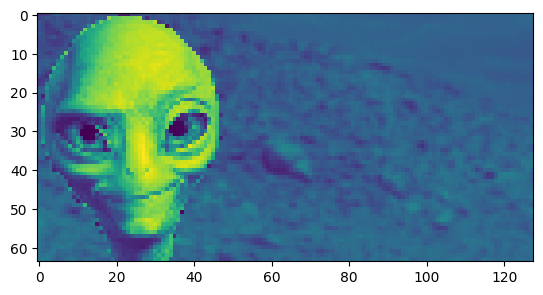

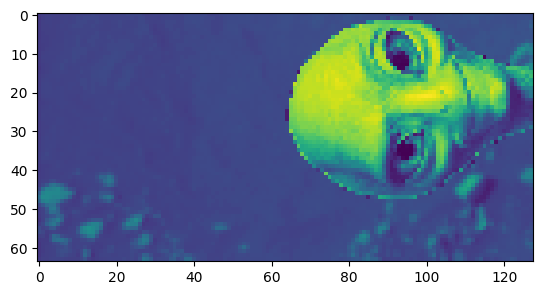

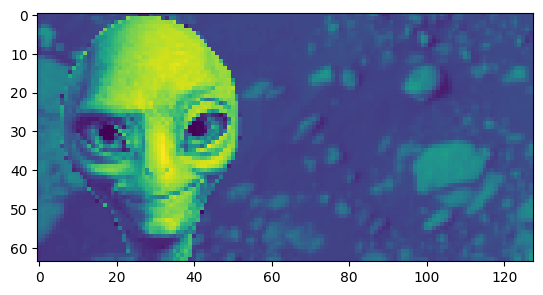

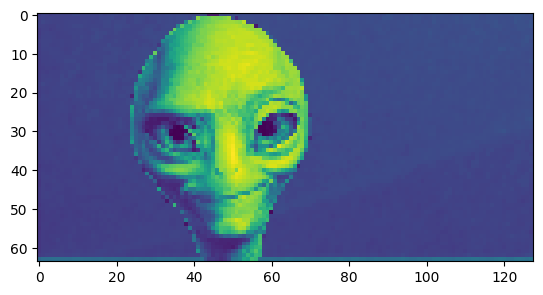

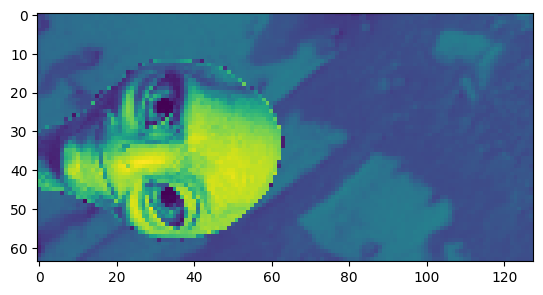

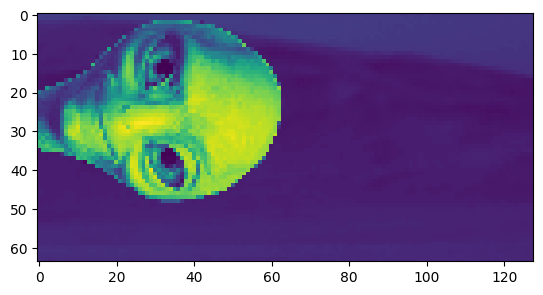

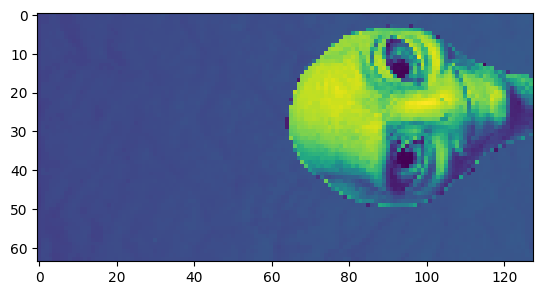

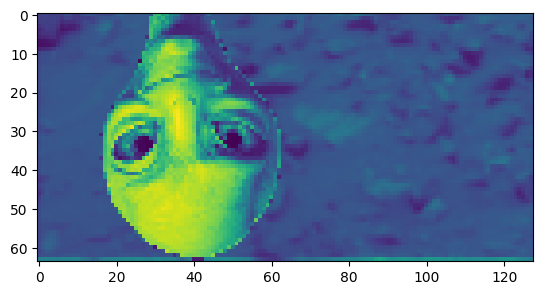

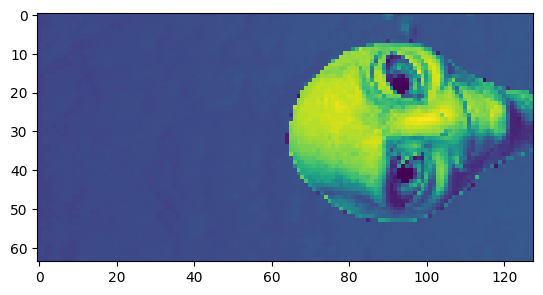

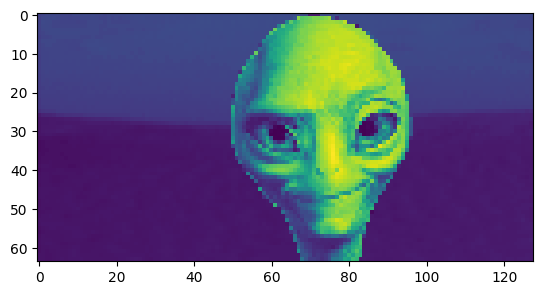

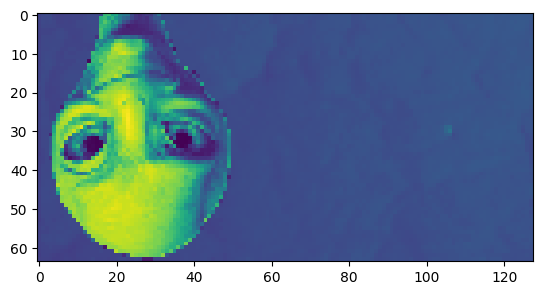

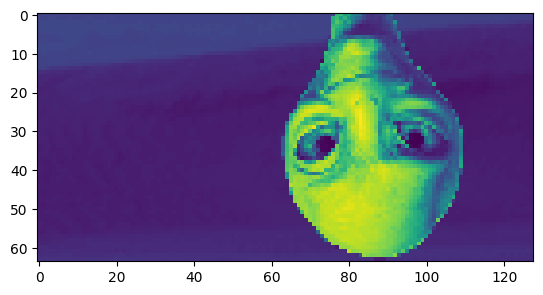

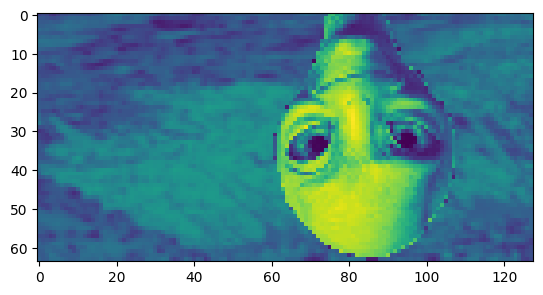

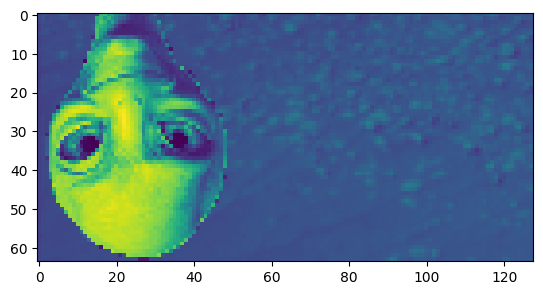

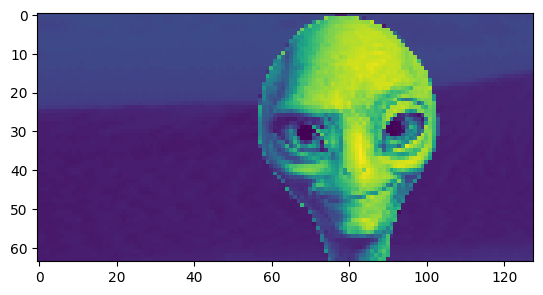

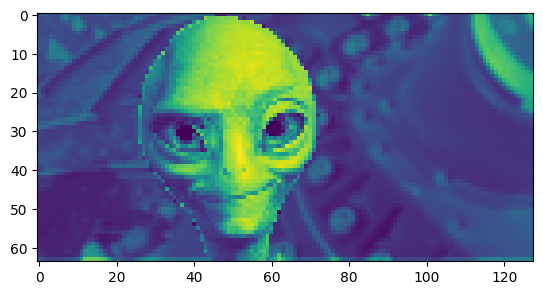

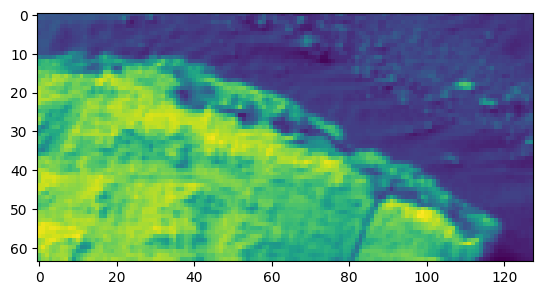

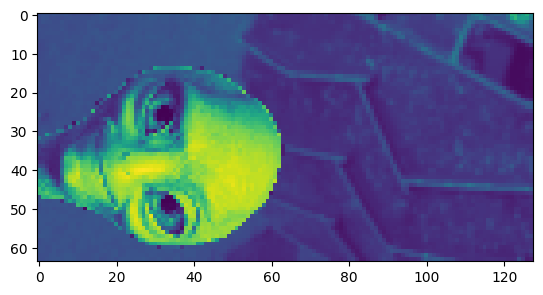

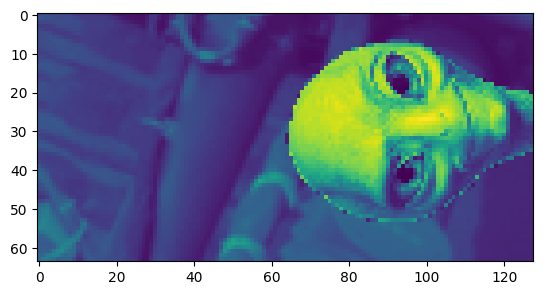

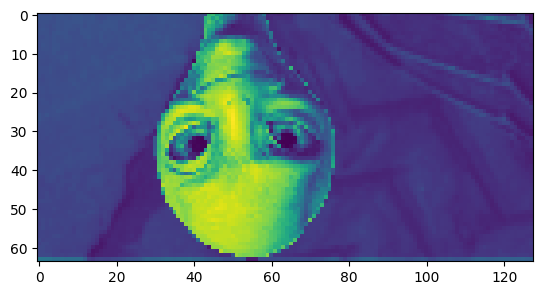

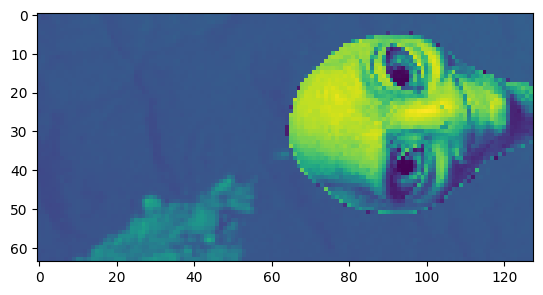

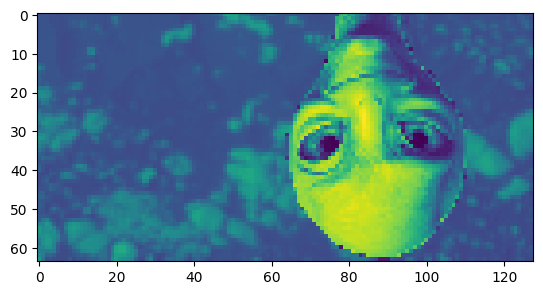

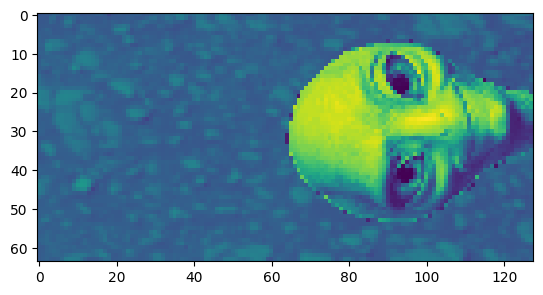

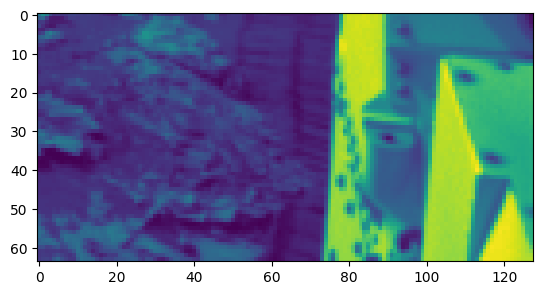

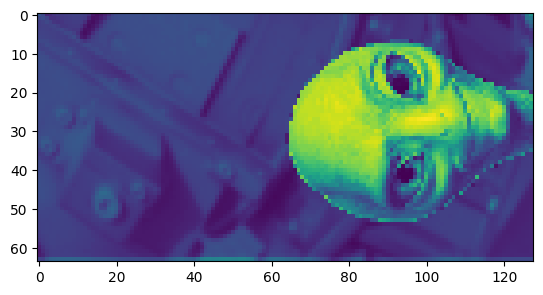

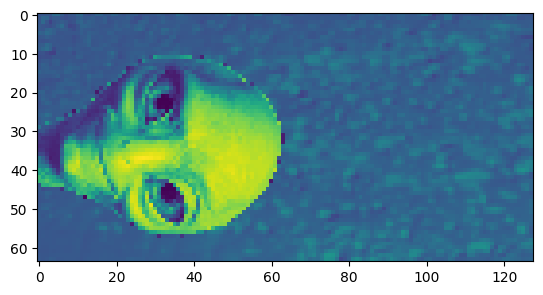

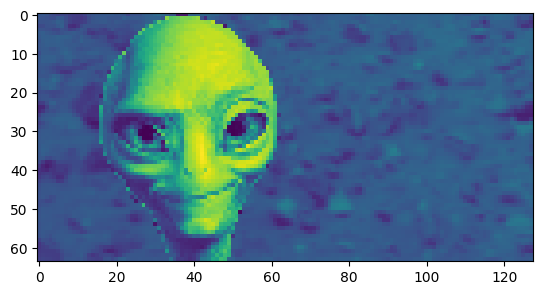

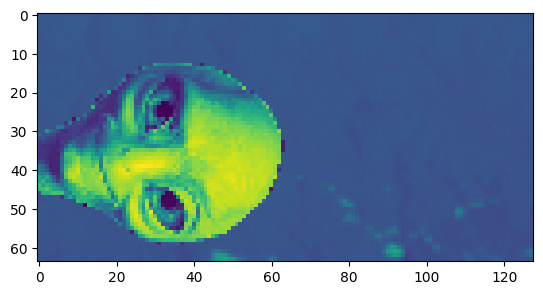

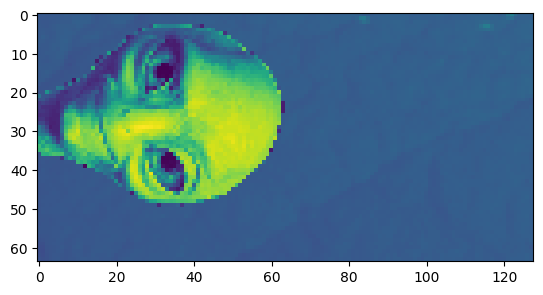

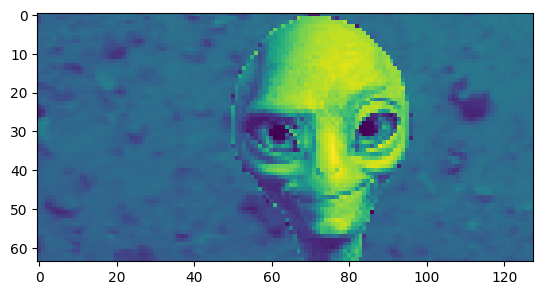

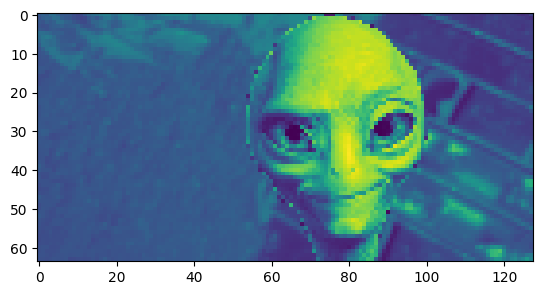

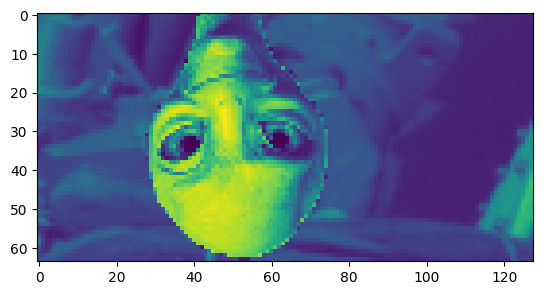

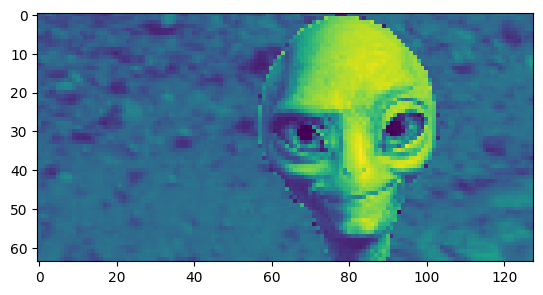

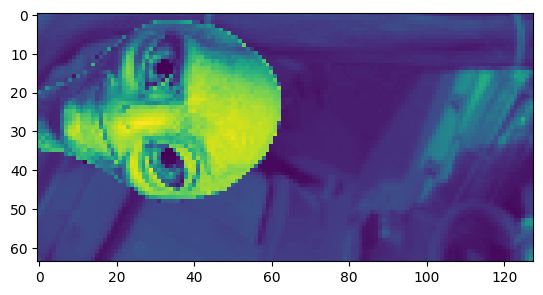

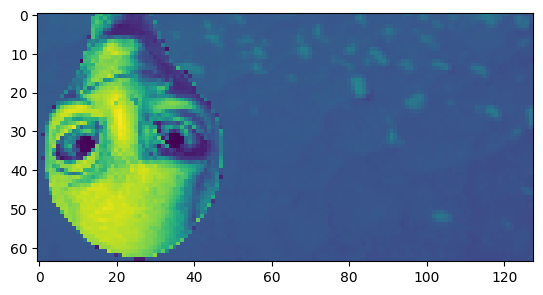

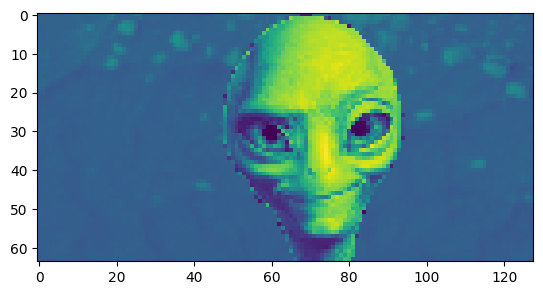

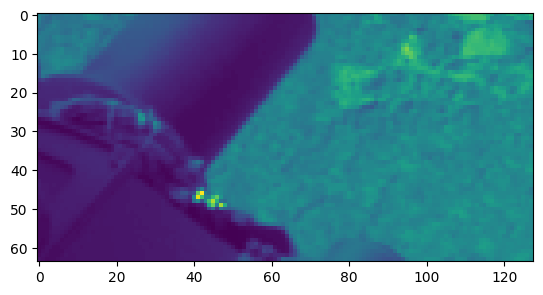

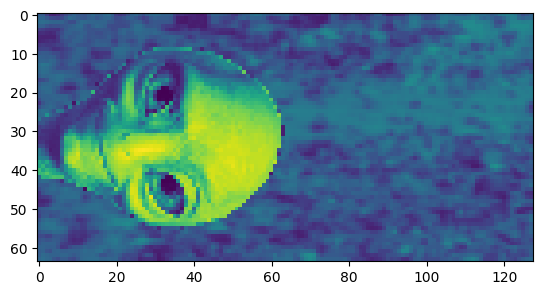

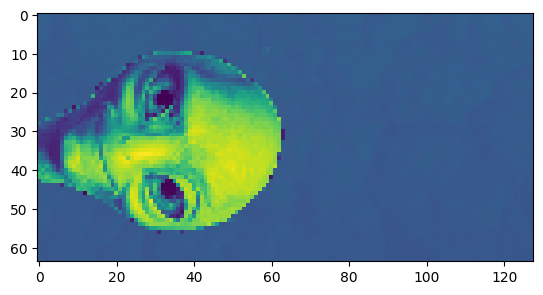

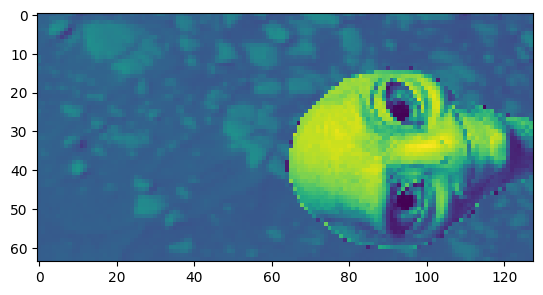

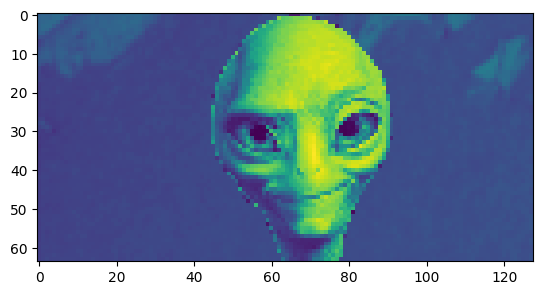

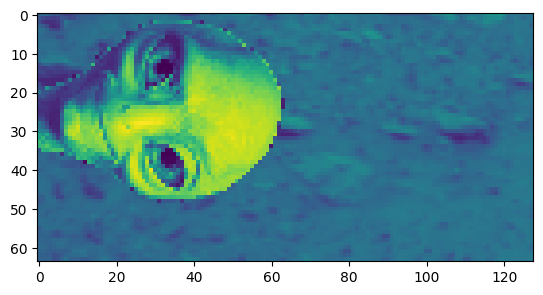

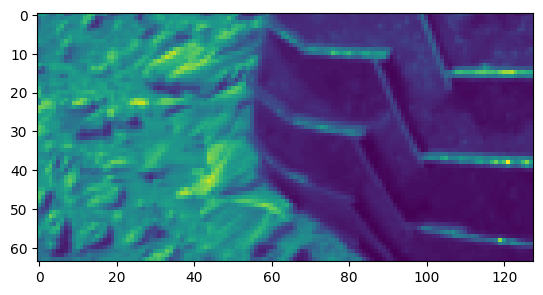

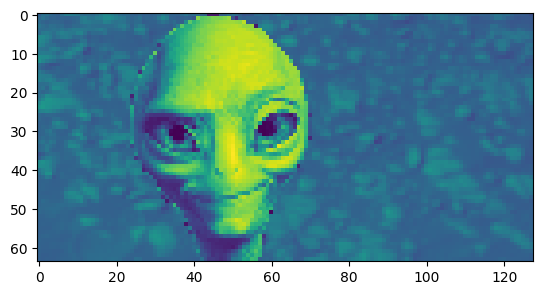

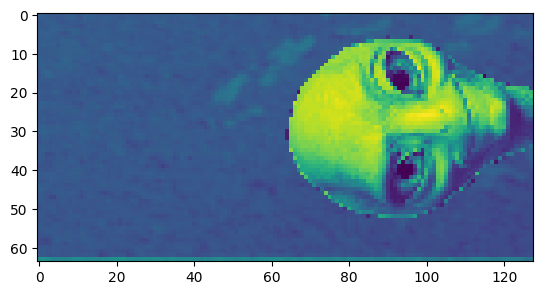

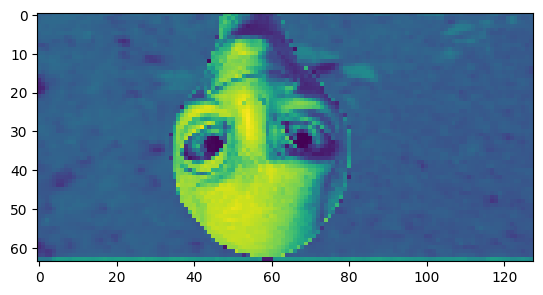

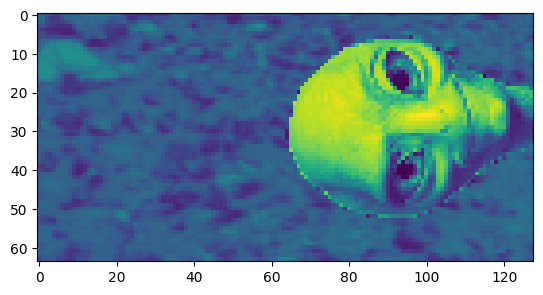

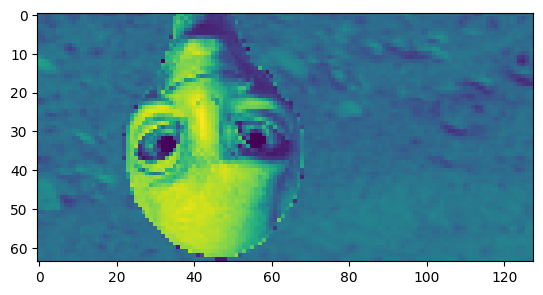

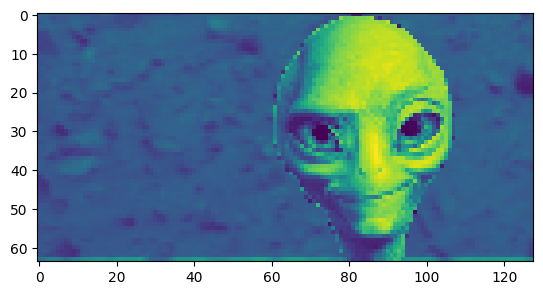

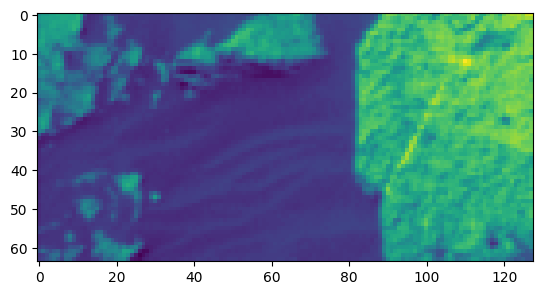

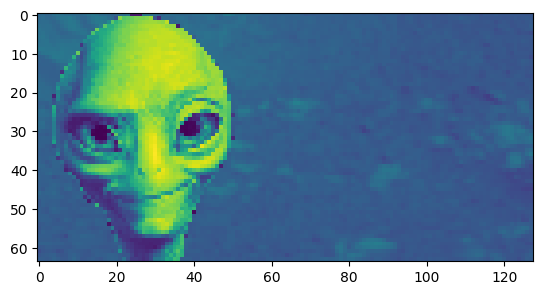

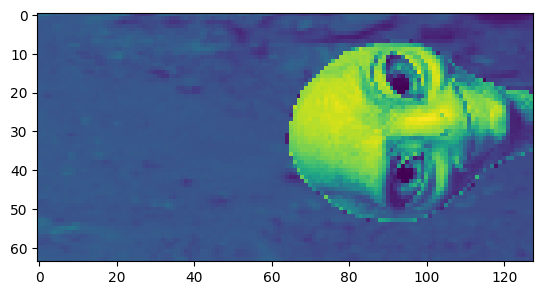

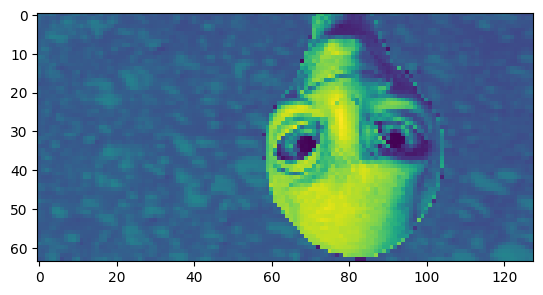

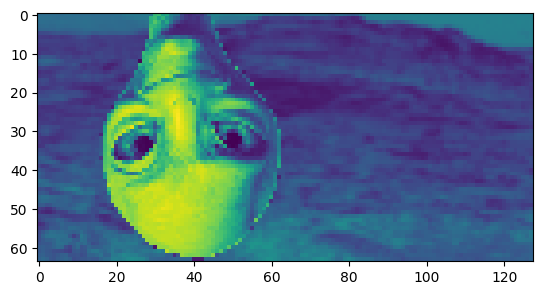

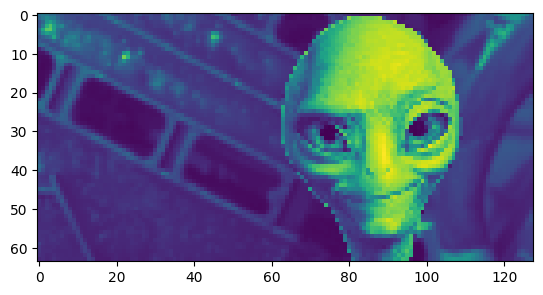

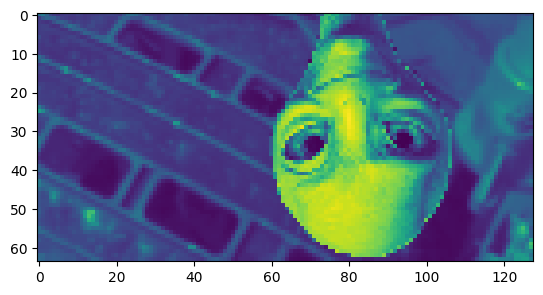

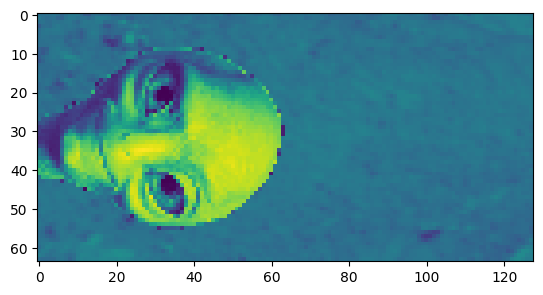

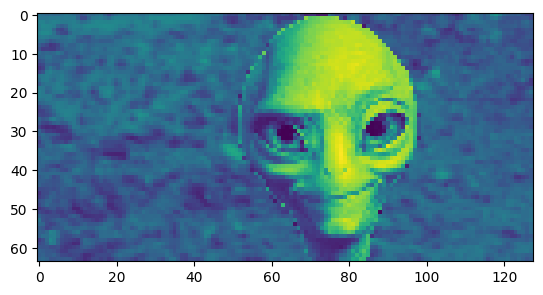

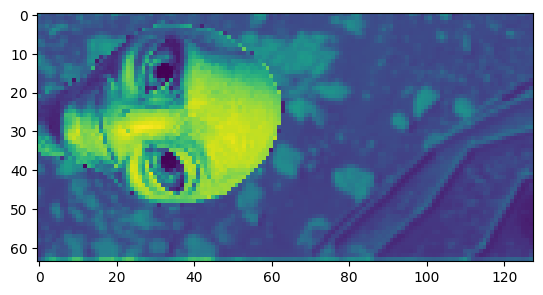

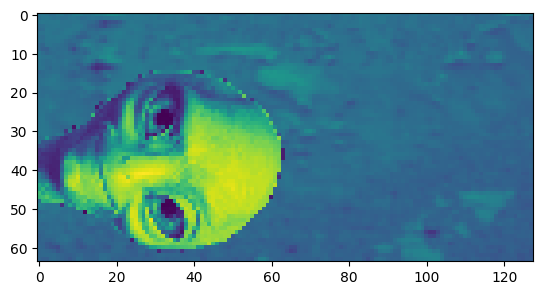

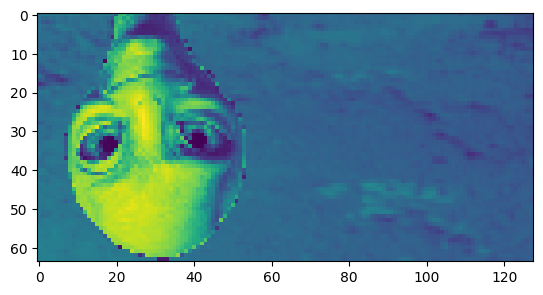

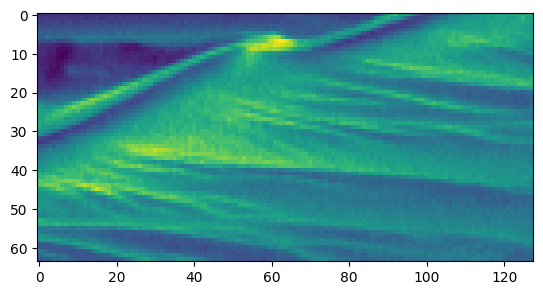

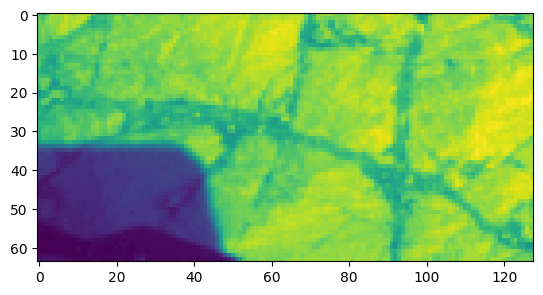

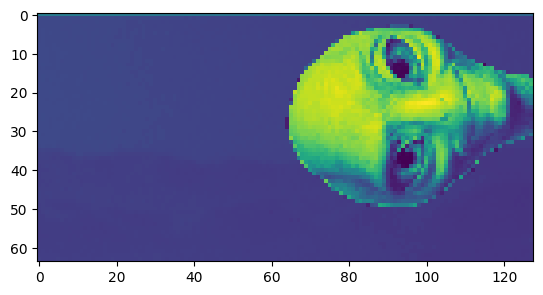

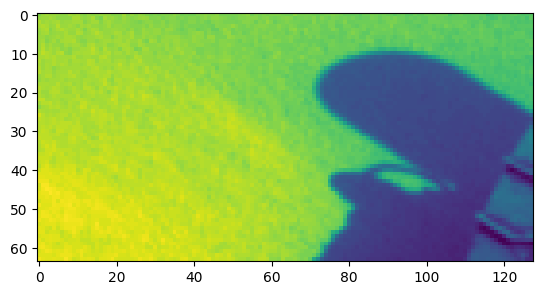

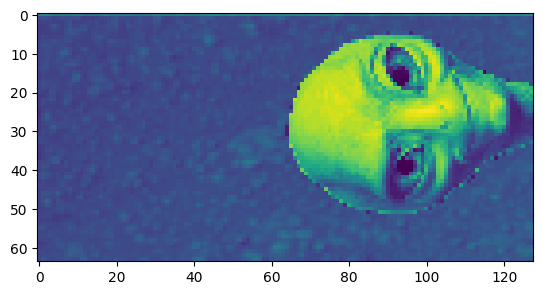

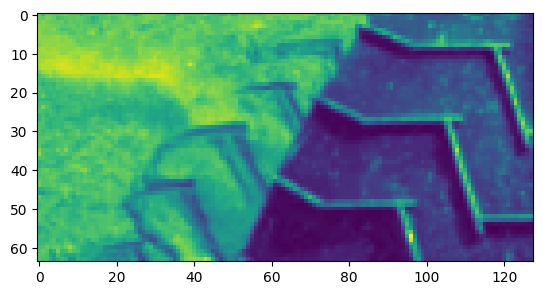

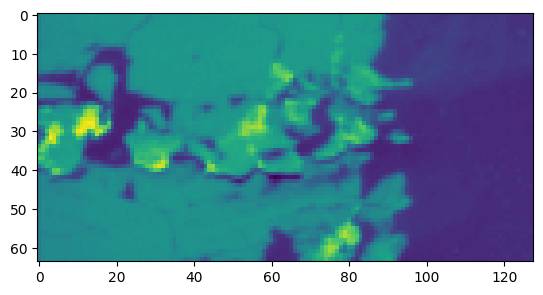

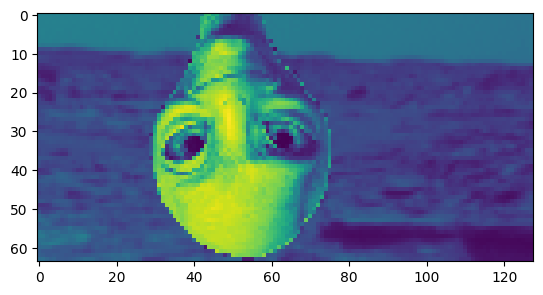

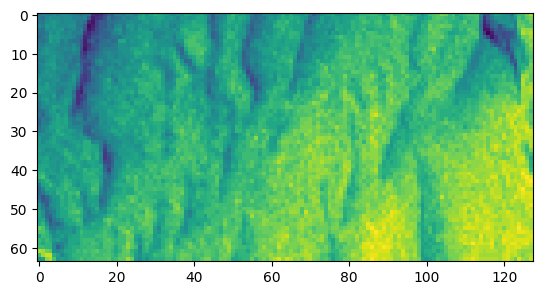

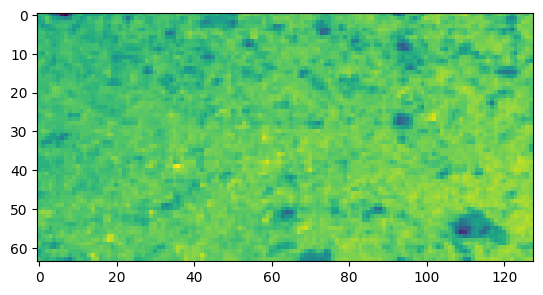

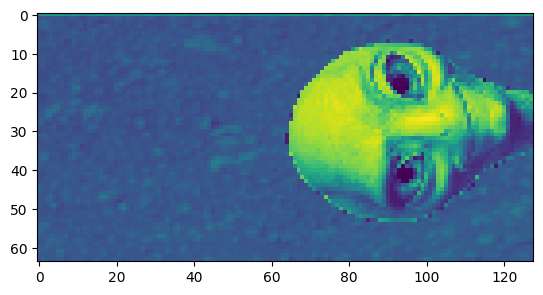

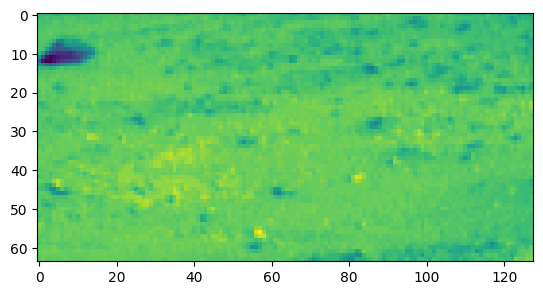

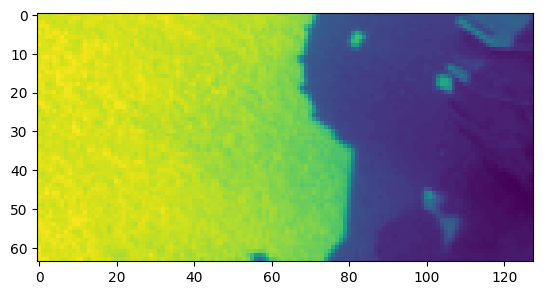

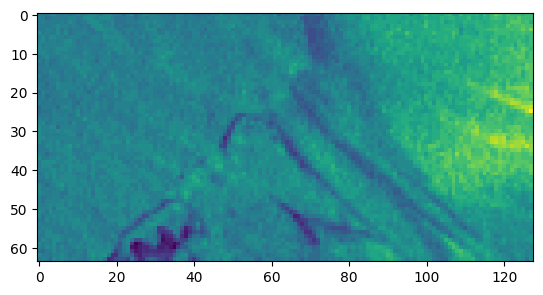

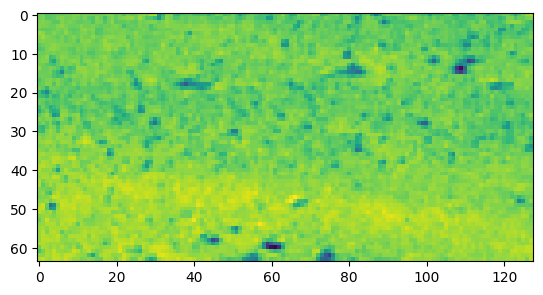

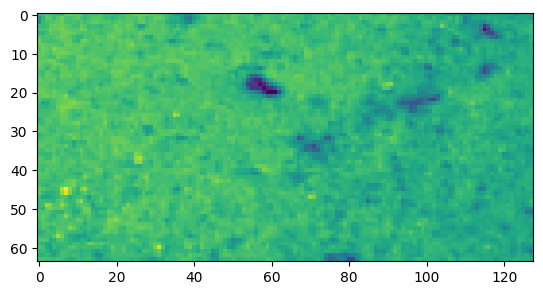

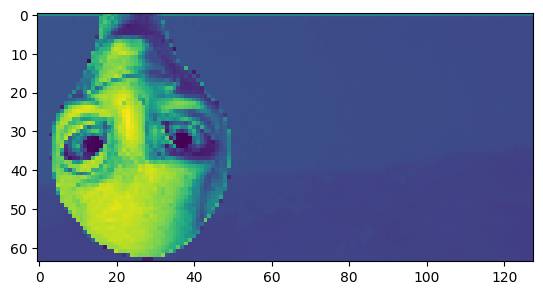

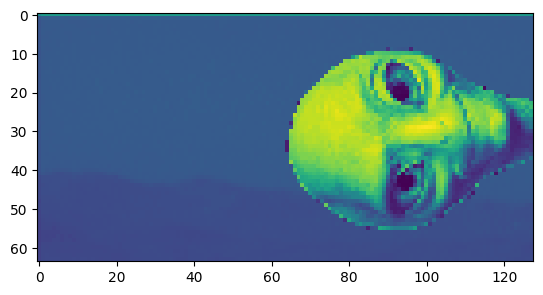

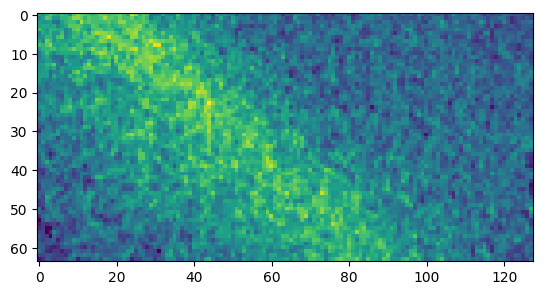

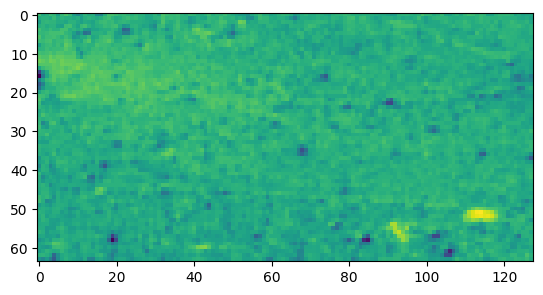

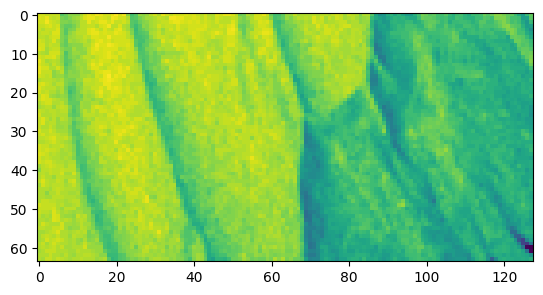

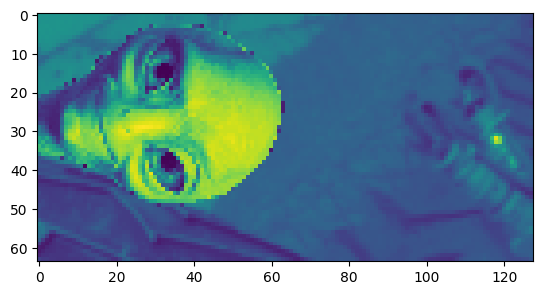

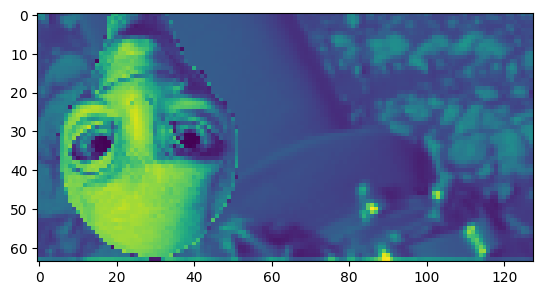

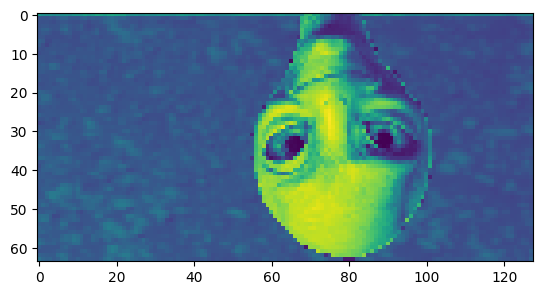

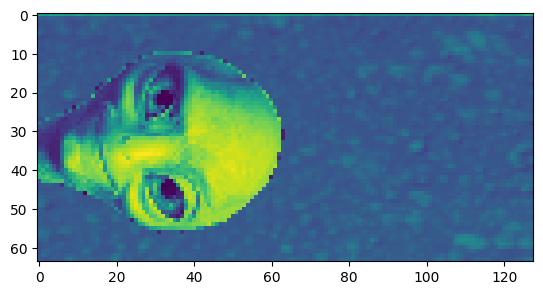

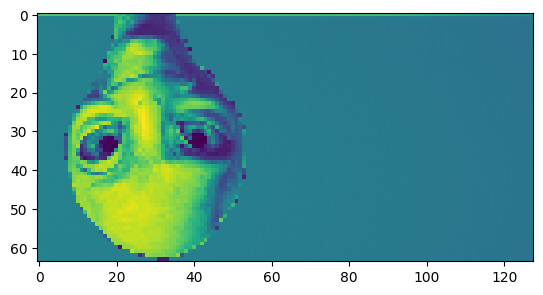

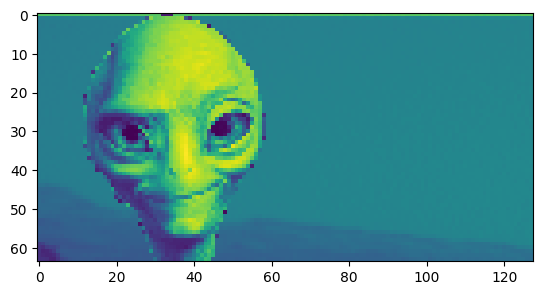

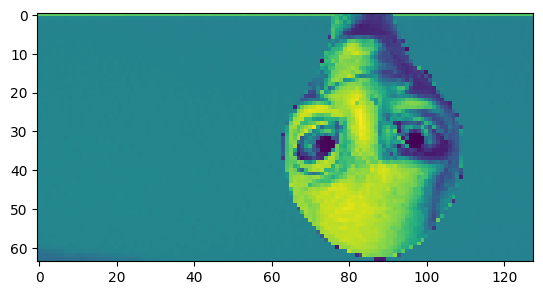

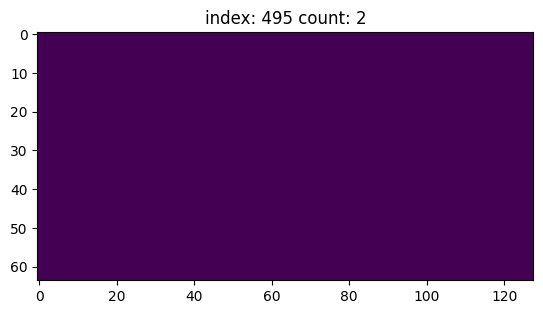

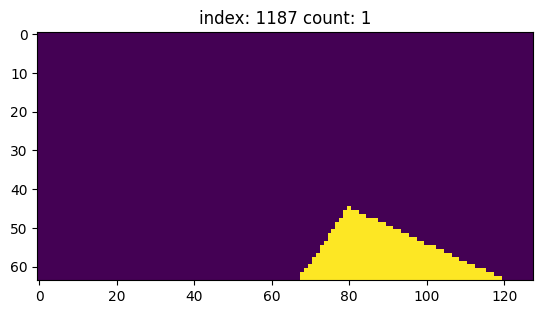

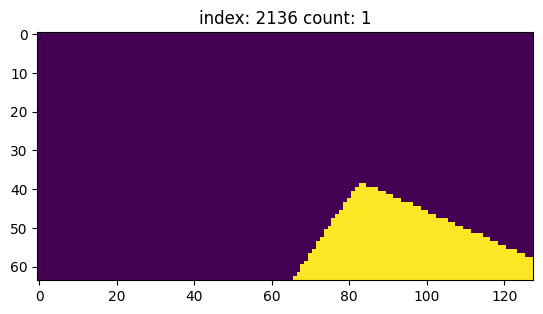

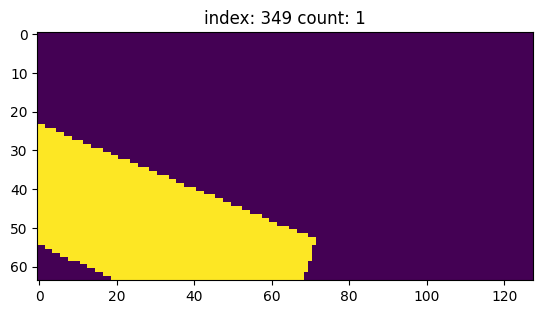

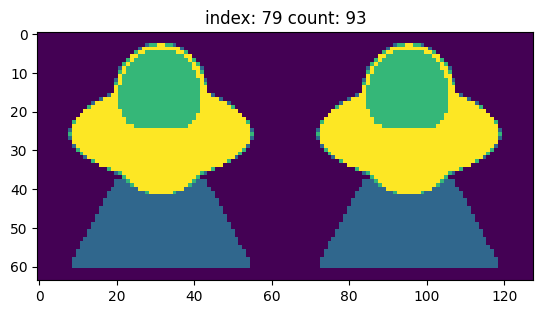

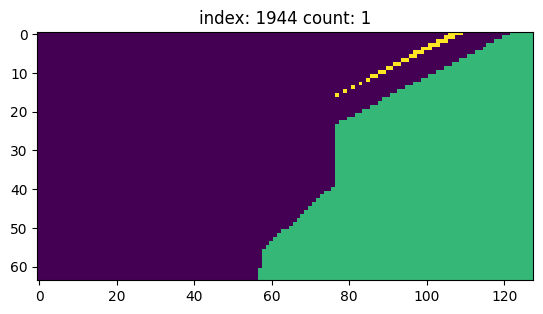

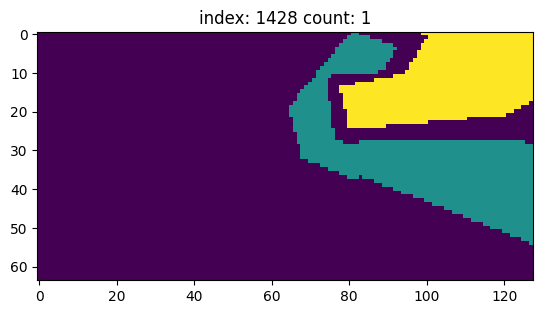

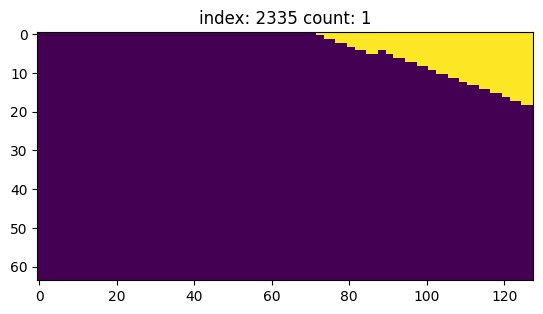

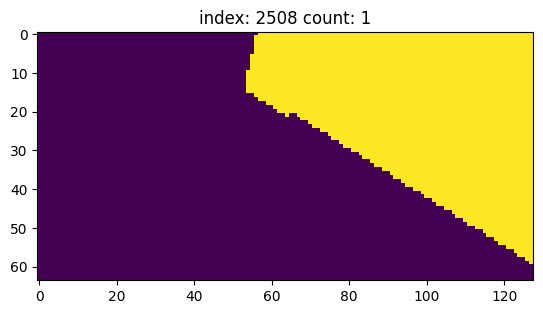

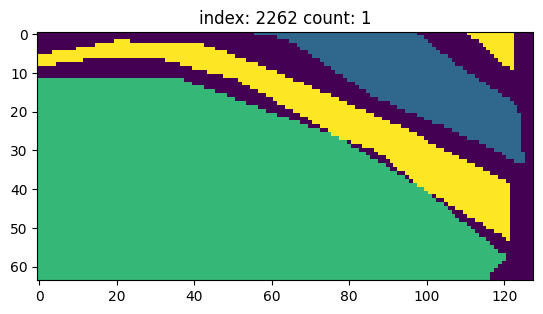

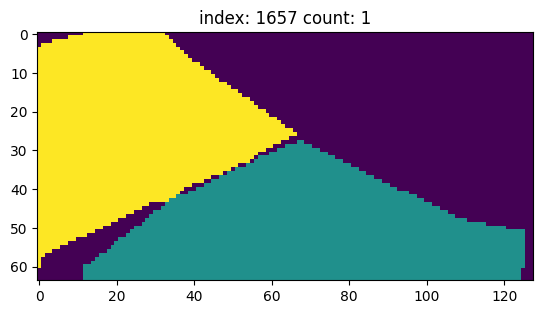

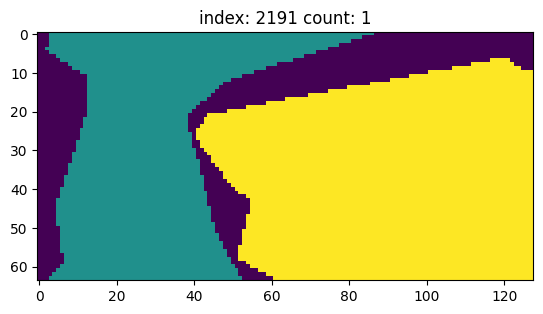

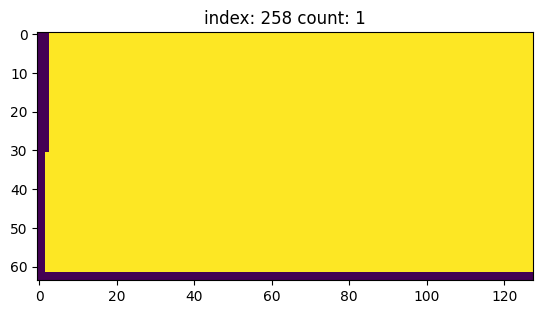

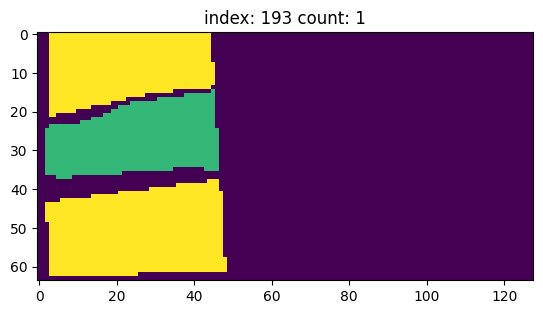

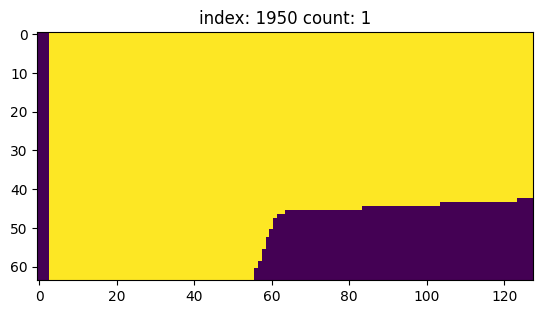

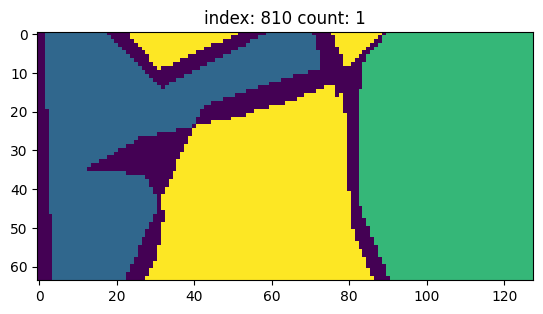

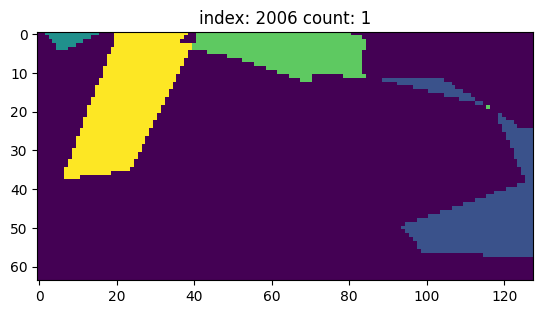

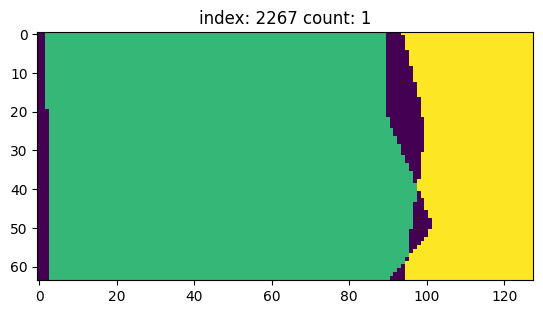

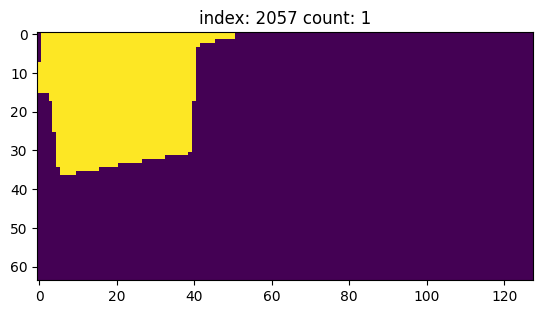

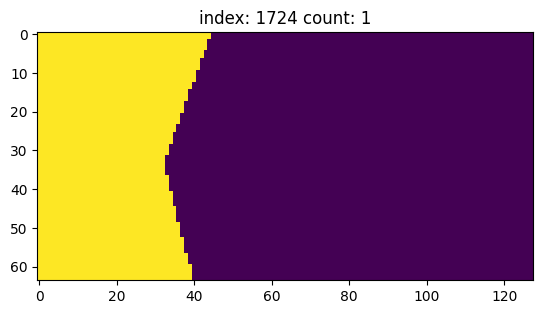

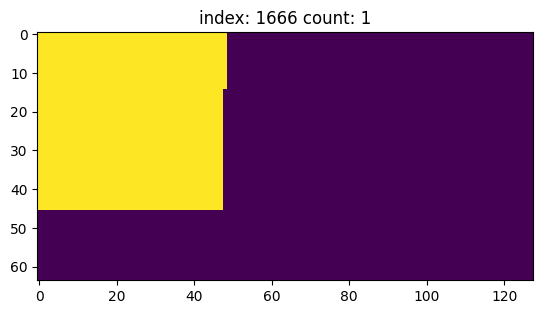

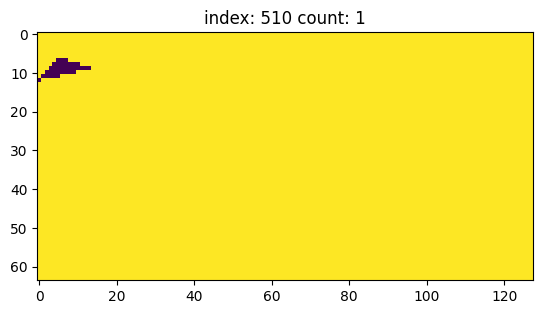

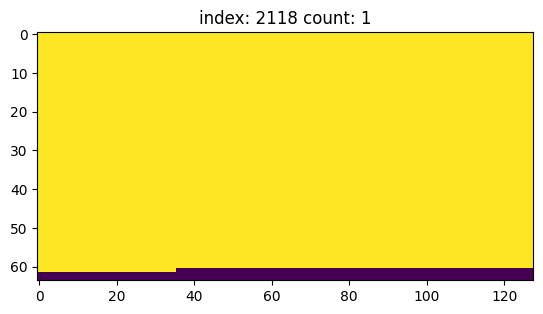

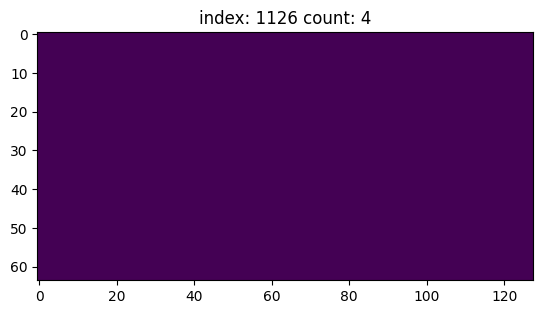

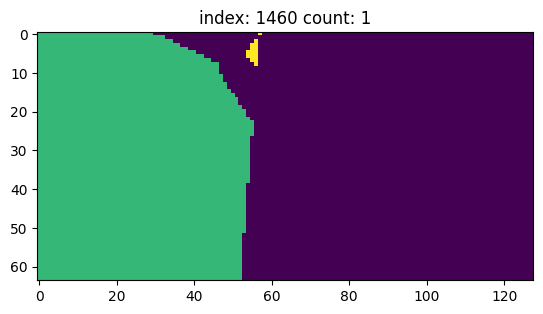

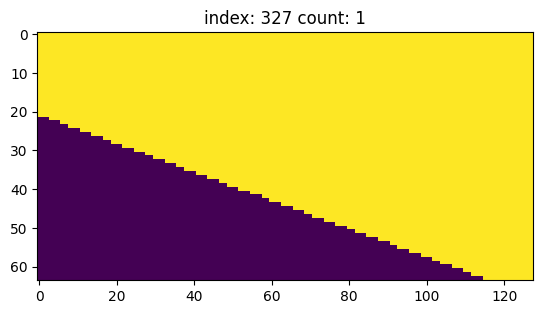

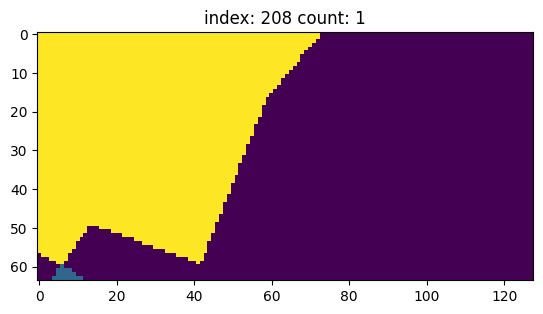

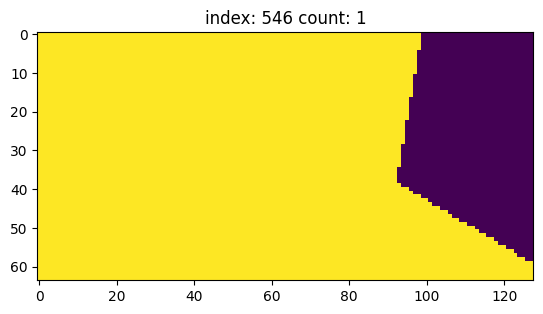

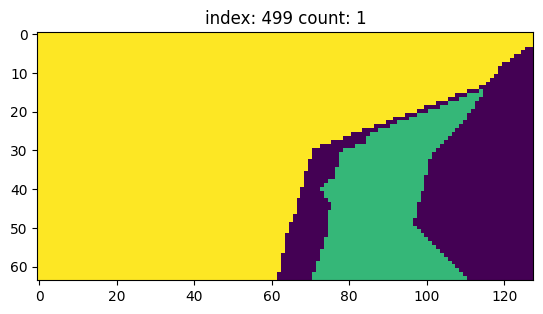

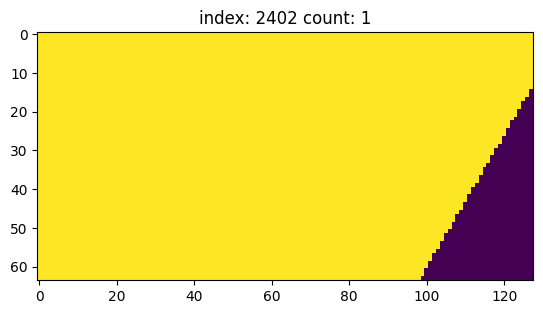

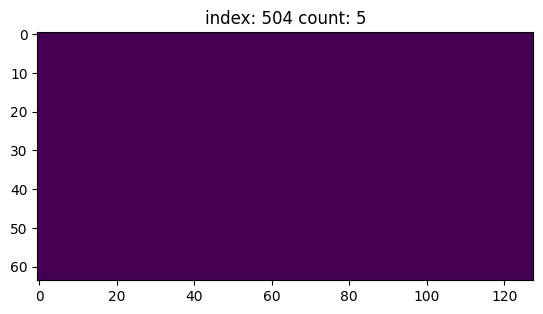

In [ ]:
# Compute mahalanobis distance to find outliers
mahalanobis_distances = [distance.mahalanobis(x, np.mean(scores,axis=0), np.linalg.inv(np.cov(scores.T))) for x in scores]

# Get 0.1% furthest images
percentiles = np.percentile(mahalanobis_distances, 95)
outliers = np.where(mahalanobis_distances > percentiles)[0]

uniques = np.unique(X_train[outliers],axis=0)

#Plot outliers
for i in range(len(uniques)):
    plt.figure()
    plt.imshow(uniques[i])
plt.show()

uniquesy, idx, counts = np.unique(y_train[outliers],axis=0,return_counts=True, return_index = True)
for i in range(len(uniquesy)):
    plt.figure()
    plt.imshow(uniquesy[i])
    plt.title('index: ' + str(outliers[idx[i]]) + ' count: ' + str(counts[i]))
plt.show()

## 4 Process Data

### 4.1 Outlier removal

2505
(2505, 64, 128)
(2505, 64, 128)


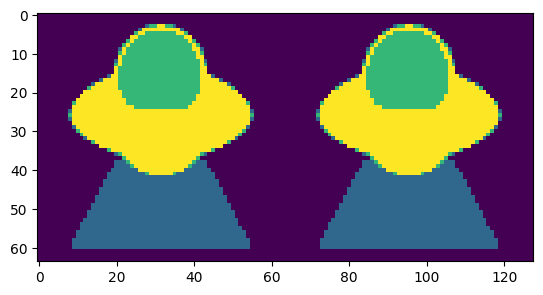

In [ ]:
# we identified the duplicated images and found that the index of the alien is 79
Alien = y_train[79]
plt.figure()
plt.imshow(Alien)

# remove outliers
idxRemove = []
for i, img in enumerate(y_train):
  if np.array_equal(img, Alien):
    idxRemove.append(i)

X_train = np.delete(X_train, idxRemove, axis = 0)
y_train = np.delete(y_train, idxRemove, axis = 0)

print(len(y_train))
print(np.shape(y_train))
print(np.shape(X_train))


### 4.2 Colormap definition and visualization

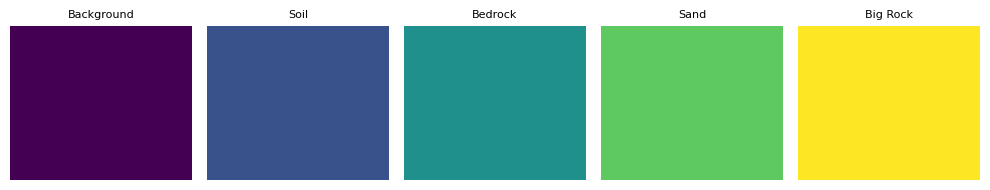

In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)


    if colormap is None:
        colormap = create_segmentation_colormap(5)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored


def visualize_colormap(colormap, num_classes):
    """
    Visualize the colormap and its association with class indices.
    """
    plt.figure(figsize=(10, 2))
    for i, color in enumerate(colormap):
        plt.subplot(1, num_classes, i + 1)
        plt.imshow([[color]], aspect='auto')
        plt.axis('off')
        plt.title(classes[i], fontsize=8)
    plt.tight_layout()
    plt.show()

# number of classes
num_classes = 5

# colormap generation
colormap = create_segmentation_colormap(num_classes)

# colormap visualization
visualize_colormap(colormap, num_classes)

### 4.3 Data visualization

In [ ]:
def plot_sample_batch(images,labels):
    """
    Display some image and label pairs from the dataset.
    """
    num_samples=len(images)
    plt.figure(figsize=(15, 4*num_samples))
    colormap = create_segmentation_colormap(5)
    #print(np.shape(images))
    if np.shape(images)==(64, 128):
      plt.subplot(1,2,1)
      plt.imshow(X_train[31],cmap='gray')
      plt.axis('off')

      plt.subplot(1,2,2)
      plt.imshow(apply_colormap(y_train[31]))
      plt.axis('off')
      plt.show()
      plt.close()
    else:
      print(len(images))
      for j in range(len(images)):
          # Plot original image
          plt.subplot(num_samples, 2, j*2 + 1)
          plt.imshow(images[j],cmap='gray')
          plt.title(f'Image {j+1}')
          plt.axis('off')

          # Plot colored label
          plt.subplot(num_samples, 2, j*2 + 2)
          #print(np.shape(labels[j]))
          colored_label = apply_colormap(labels[j], colormap)
          plt.imshow(colored_label)
          plt.title(f'Label {j+1}')
          plt.axis('off')

      plt.tight_layout()
      plt.show()
      plt.close()
# Visualize examples from the training set

### 4.4 Normalizing and rescaling the data

In [ ]:
unique, count = np.unique(y_train, return_counts=True)
print('Target labels:', unique)
for i in range(len(unique)):
    print(f'Class {unique[i]} has {count[i]} samples')

# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0
y_train=y_train[..., np.newaxis]

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Target labels: [0 1 2 3 4]
Class 0 has 4988826 samples
Class 1 has 6957538 samples
Class 2 has 4776810 samples
Class 3 has 3770823 samples
Class 4 has 26963 samples
Input shape: (64, 128, 1)
Number of classes: 5


## 6 Define Network Parameters

In [ ]:
# Set batch size for training
batch_size = 32

# Set learning rate for the optimiser
learning_rate = 1e-3

# Set early stopping patience threshold
patience = 15

# Set maximum number of training epochs
epochs = 350

## 7 Label Refinement

### 7.1 Label correction for general images

In [ ]:
from sklearn.utils import shuffle

data_bigrocks = np.load("/kaggle/input/martemarte/updated_dataset_orrible.npz")

# extraction of the data
X_0 = data_bigrocks["X"]
Y_0 = data_bigrocks["Y"]

X_0 = X_0[..., np.newaxis] / 255.0
Y_0=Y_0[..., np.newaxis]
print(len(X_0))

X_0[21] # eliminated
X_0 = np.delete(X_0, [21], axis=0)
Y_0 = np.delete(Y_0, [21], axis=0)


for i in range(len(X_0)):
  imag_nuova=X_0[i]
  indices_to_remove = []
  for i, img in enumerate(X_train):
      if np.array_equal(img, imag_nuova):
          indices_to_remove.append(i)


  X_train = np.delete(X_train, indices_to_remove, axis=0)
  y_train = np.delete(y_train, indices_to_remove, axis=0)
  #print(indices_to_remove)

X_train=np.concatenate([X_train, X_0],axis=0)
y_train=np.concatenate([y_train, Y_0],axis=0)

X_train, y_train = shuffle(X_train, y_train, random_state=42)

39


### 7.2 Label correction for images with class 4

In [ ]:
#from sklearn.utils import shuffle

data_bigrocks = np.load("/kaggle/input/martemarte/updated_dataset.npz")

# extraction of the data
X = data_bigrocks["X"]
Y = data_bigrocks["Y"]

X = X[..., np.newaxis] / 255.0
Y=Y[..., np.newaxis]


# if i want ot remove nont precise labels
for i in range(len(X)):
  imag_nuova=X[i]
  indices_to_remove = []
  for i, img in enumerate(X_train):
      if np.array_equal(img, imag_nuova):
          indices_to_remove.append(i)

  X_train = np.delete(X_train, indices_to_remove, axis=0)
  y_train = np.delete(y_train, indices_to_remove, axis=0)
  print(indices_to_remove)

X_train=np.concatenate([X_train, X],axis=0)
y_train=np.concatenate([y_train, Y],axis=0)


X_train, y_train = shuffle(X_train, y_train, random_state=42)

[776]
[594]
[965]
[2138]
[1867]
[1678]
[976]
[1137]
[1931]
[307]
[226]
[693]
[530]
[2370]
[358]
[1664]
[1637]
[2129]
[571]
[1292]
[1190]
[176]
[1113]
[354]
[1017]
[885]
[1934]
[896]
[1294]
[1340]
[1582]
[949]


## 8 Data Splitting

In [ ]:
# Split into training, validation, and test sets

split_size = 350

print("Splitting data...")
# X_train_val, X_testing, y_train_val, y_testing = train_test_split(
#     X_train, y_train, test_size=100, random_state=seed
# )
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=split_size, random_state=seed
)
print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
#print(f"Test: {len(X_testing)}")

Splitting data...
Data splitted!

Number of images:
Train: 2155
Validation: 350


## 9 Augmentation

Augmentation:

*   random flipping
*   random contrast
*   random brightness





In [ ]:
def random_flip_lr(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)

    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label


def random_flip_ud(image, label, seed = seed):
    """Consistent random horizontal flip."""
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_up_down(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_up_down(label),
        lambda: label
    )
    return image, label

def random_contrast(image, label, seed = seed):
    """Randomly adjust contrast of the image."""
    contrast_factor = tf.random.uniform([], 0.85, 1.15, seed = seed)
    image = tf.image.adjust_contrast(image, contrast_factor)
    return image, label

def random_brightness(image, label, seed = seed):
    """Randomly adjust brightness of the image."""
    brightness_delta = tf.random.uniform([], -0.1, 0.1, seed = seed)
    image = tf.image.adjust_brightness(image, brightness_delta)
    return image, label

In [ ]:
# # Funzione di augmentation sincronizzata
# def aug_rot(image, label, seed=seed):
#     # Crea un generatore randomico con il seed fornito
#     use_prob = tf.random.uniform([],seed=seed)
#     rotation_angle = tf.random.uniform([], minval=-0.3, maxval=0.3,seed=seed)

# # fill_mode: str = 'reflect',

#     image = tf.cond(
#         use_prob > 0.5,
#         lambda: tfa.image.rotate(image, rotation_angle,fill_mode='reflect'),
#         lambda: image
#     )
#     label = tf.cond(
#         use_prob > 0.5,
#         lambda: tfa.image.rotate(label, rotation_angle,fill_mode='reflect'),
#         lambda: label
#     )



#     return image, label

Function to decide which augmentation to apply

In [ ]:
def flipping(image, label, seed = seed):

    image, label=random_flip_lr(image, label, seed=seed)
    image, label=random_flip_ud(image, label, seed=seed)

    return image, label

In [ ]:
# We now add multiple times the hand-made images with big_rocks to balance the dataset

index=[];
for i in range(len(y_train)):# parte da 0 e arriva a len(X_train)-1, dunque li scorre tutti
  if (np.any(y_train[i]==4)==True):
    index.append(i)


dataset = tf.data.Dataset.from_tensor_slices((X, Y))
dataset = dataset.map(
    lambda x, y: flipping(x, y),
)


image_tensor = tf.stack([x for x, _ in dataset],axis=0)
label_tensor = tf.stack([y for _, y in dataset],axis=0)

# Convertire in NumPy arrays
image_array = image_tensor.numpy()
label_array = label_tensor.numpy()


for i in range(4):
    X_train=np.concatenate([X_train, image_array],axis=0)
    y_train=np.concatenate([y_train, label_array],axis=0)

X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [ ]:
def one_hot_encode(image, label):
    label = tf.squeeze(label, axis=-1)
    label = tf.one_hot(label, depth=5)  # Convert to one-hot
    return image, label

# Map the one-hot encoding function to the dataset

## 10 Making the dataset

In [ ]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 3, seed=seed)

    if augment:
        dataset = dataset.map(
            lambda x, y: flipping(x, y),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset = dataset.map(one_hot_encode,num_parallel_calls=tf.data.AUTOTUNE)


    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
# Training dataset (augmentation)
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=batch_size,
    shuffle=True,
    augment=True,
    seed=seed
)


# Validation dataset (no augmentation)
val_dataset = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .map(one_hot_encode, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)# applico data augmentation al batch
    .prefetch(buffer_size=tf.data.AUTOTUNE)# per ottimizzare l'efficienza, precarico i dati del batch successivo
)

## 11 Train and Save the Model

### 11.1 Model implementation

Defining the unet_block

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, initializer=None,regularizer=None, name='', dilr = 1):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', dilation_rate = dilr, kernel_initializer=initializer, kernel_regularizer=regularizer, name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

Defining of the aspp block

In [ ]:
def aspp_block(x, filters, initializer, regularizer):
    activation = 'relu'
    aspp1 = tfkl.Conv2D(filters, kernel_size = 1, kernel_initializer=initializer, padding="same")(x)
    aspp1 = tfkl.BatchNormalization()(aspp1)
    #aspp1 = tfkl.ReLU()(aspp1)
    aspp1 = tfkl.Activation(activation)(aspp1)

    aspp2 = tfkl.Conv2D(filters, kernel_size = 3, kernel_initializer=initializer, kernel_regularizer=regularizer, dilation_rate=6, padding="same")(x)
    aspp2 = tfkl.BatchNormalization()(aspp2)
    aspp2 = tfkl.Activation(activation)(aspp2)

    aspp3 = tfkl.Conv2D(filters, kernel_size = 3,kernel_initializer=initializer,  kernel_regularizer=regularizer, dilation_rate=12, padding="same")(x)
    aspp3 = tfkl.BatchNormalization()(aspp3)
    aspp3 = tfkl.Activation(activation)(aspp3)

    aspp4 = tfkl.Conv2D(filters, kernel_size = 3,kernel_initializer=initializer,  kernel_regularizer=regularizer,dilation_rate=18, padding="same")(x)
    aspp4 = tfkl.BatchNormalization()(aspp4)
    aspp4 = tfkl.Activation(activation)(aspp4)

    pooled = tfkl.GlobalAveragePooling2D()(x)
    pooled = tfkl.Reshape((1,1, pooled.shape[-1]))(pooled)
    pooled = tfkl.Conv2D(filters, kernel_size = 1, kernel_initializer=initializer,  kernel_regularizer=regularizer, padding="same")(pooled)
    pooled = tfkl.BatchNormalization()(pooled)
    pooled = tfkl.Activation(activation)(pooled)
    pooled = tfkl.UpSampling2D(size = (x.shape[1], x.shape[2]), interpolation = 'nearest')(pooled)
    concatenation = tfkl.Concatenate()([aspp1, aspp2, aspp3, aspp4, pooled])

    output = tfkl.Conv2D(filters, kernel_size = 1, kernel_initializer=initializer, kernel_regularizer=regularizer, padding="same")(concatenation)
    output = tfkl.BatchNormalization()(output)
    output = tfkl.Activation(activation)(output)

    #output = tfkl.Dropout(0.2)(output)

    return output

Defining the model

In [ ]:
def get_unet_model2(input_shape=(64, 128, 1), num_classes=5, seed=seed):
    tf.random.set_seed(seed)
    initializer=tfk.initializers.HeNormal(seed=seed)

    l2_lambda= 5*1e-4
    regularizer = tfk.regularizers.l2(l2_lambda) #questa sarebbe la ridge regression (sarebbe weight decay ma fatta solo sui pesi dell'ultimo layer)

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')


    x=input_layer
    #augmentation = tf.keras.Sequential([
    #     tfkl.RandomContrast(0.3),
    #     ], name='preprocessing')
    #x = augmentation(input_layer)



    # Downsampling path
    down_block_1 = unet_block(x, 32, initializer=initializer,name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, initializer=initializer,name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, initializer=initializer,name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck
    #bottleneck = unet_block(d3, 256, initializer=initializer, regularizer=regularizer, name='bottleneck')
    bottleneck = aspp_block(d3, 256, initializer, regularizer)



    u1 = tfkl.UpSampling2D(size=(2, 2),interpolation="nearest")(bottleneck)
    u1=tfkl.Conv2D(filters=128,kernel_size=3,padding="same",kernel_initializer=initializer)(u1)
    u1 = tfkl.Concatenate()([u1, down_block_3])
    u1 = unet_block(u1, 128,initializer=initializer, regularizer=regularizer,name='up_block1_')

    u2 = tfkl.UpSampling2D(size=(2, 2),interpolation="nearest")(u1)
    u2=tfkl.Conv2D(filters=64,kernel_size=3,padding="same",kernel_initializer=initializer)(u2)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 64,initializer=initializer, name='up_block2_')

    u3=tfkl.UpSampling2D(size=(2, 2),interpolation="nearest")(u2)
    u3=tfkl.Conv2D(filters=32,kernel_size=3,padding="same",kernel_initializer=initializer)(u3)
    u3 = tfkl.Concatenate()([u3, down_block_1])
    u3 = unet_block(u3, 32,initializer=initializer, name='up_block3_')


    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u3)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [ ]:
import sklearn
model = get_unet_model2()
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False,sparse_y_true=False, name='mean_iou')
optimizer=tfk.optimizers.Adam(learning_rate=0.001)

y_flat=y_train.reshape(-1)
classes=np.unique(y_flat)
print(classes)
class_weights=sklearn.utils.class_weight.compute_class_weight(class_weight='balanced',classes=classes, y=y_flat)

alpha = list(class_weights)
alpha=[0.,4.,5.,5.5,50.]
print(alpha)
loss=tfk.losses.CategoricalFocalCrossentropy(
    alpha=alpha,
    gamma=2.0,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction="sum_over_batch_size",
    name="categorical_focal_crossentropy"
)

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy",mean_iou])

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
#model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
#tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

[0 1 2 3 4]
[0.0, 4.0, 5.0, 5.5, 50.0]


### 11.2 Callbacks setup

In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=20,
    restore_best_weights=True
)

reduce_LR_onPlat=tfk.callbacks.ReduceLROnPlateau(
    monitor="val_mean_iou",
    factor=0.1,
    patience = 12,
    verbose=0,
    mode="max",
    min_delta=0.0015,
    cooldown=0,
    min_lr=1e-5
)


#viz_callback = VizCallback(X_val[2], y_val[2])
callbacks=[early_stopping, reduce_LR_onPlat]#, viz_callback]

### 11.3 Model training

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/350


I0000 00:00:1734180899.112755   12322 service.cc:145] XLA service 0x7974680052a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734180899.112823   12322 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734180899.112831   12322 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/72 ━━━━━━━━━━━━━━━━━━━━ 35:46 30s/step - accuracy: 0.2840 - loss: 10.6501 - mean_iou: 0.1067

I0000 00:00:1734180918.357520   12322 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 395ms/step - accuracy: 0.3636 - loss: 5.4133 - mean_iou: 0.2092 - val_accuracy: 0.0319 - val_loss: 38.4979 - val_mean_iou: 0.0228 - learning_rate: 0.0010
Epoch 2/350
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.4071 - loss: 3.3348 - mean_iou: 0.3228 - val_accuracy: 0.1588 - val_loss: 25.0888 - val_mean_iou: 0.0540 - learning_rate: 0.0010
Epoch 3/350
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.4831 - loss: 2.7615 - mean_iou: 0.4073 - val_accuracy: 0.1996 - val_loss: 10.8635 - val_mean_iou: 0.0875 - learning_rate: 0.0010
Epoch 4/350
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.4948 - loss: 2.4644 - mean_iou: 0.4211 - val_accuracy: 0.2783 - val_loss: 8.2115 - val_mean_iou: 0.1500 - learning_rate: 0.0010
Epoch 5/350
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.4882 - loss: 2.2961 - mean_iou: 0.4176 - val_accuracy: 0.4280 - val_loss: 2.7120 - val_mean_iou: 0.3287 - learning_rate: 0.0010
Epoch 6/350
72/72 ━━━━━━━━━━━━━━━

### 11.4 Plot training and validation loss

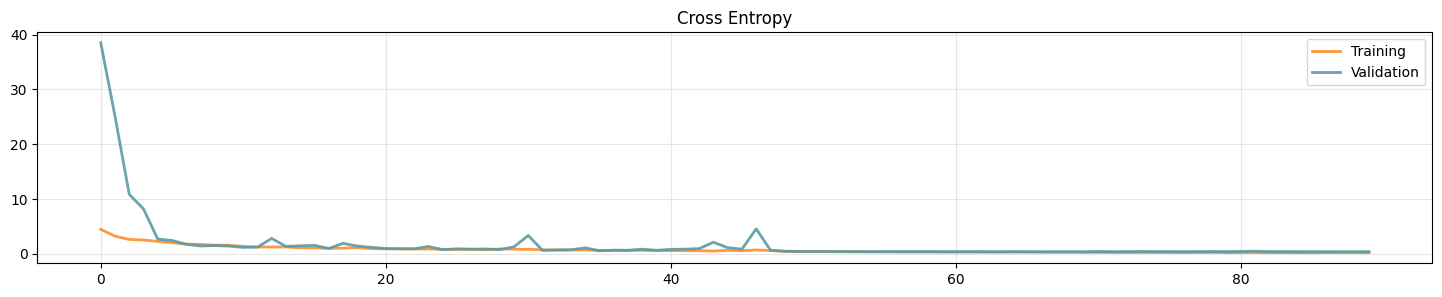

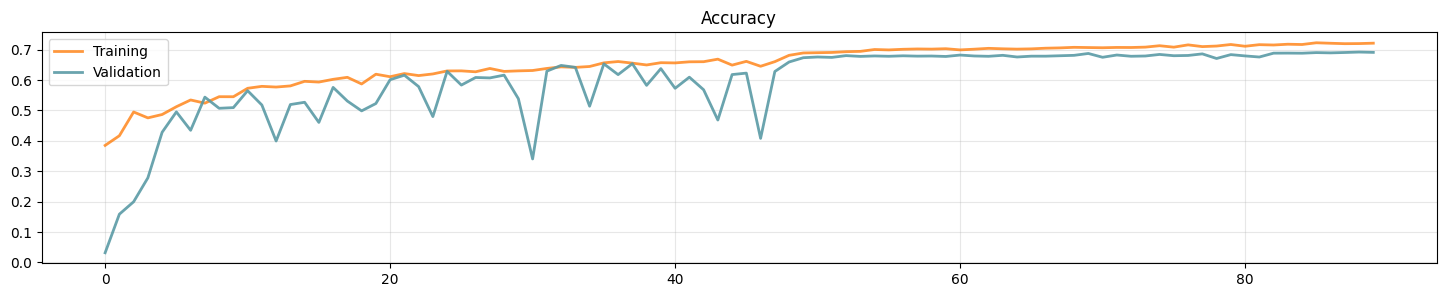

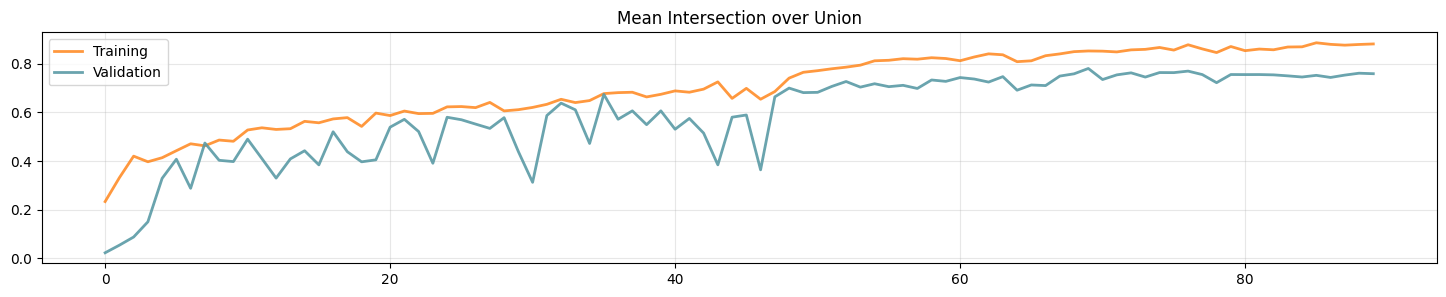

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 12 Test time augmentation (TTA)

In [ ]:
# not used in the final sub
def TTA(TestSet):
    daTTA = tfk.Sequential([
            tfkl.RandomBrightness(0.3, value_range=(0,1)),
            tfkl.RandomContrast(0.2)
    ])

    N_aug = 3
    preds = model.predict(X_test)
    predss = np.expand_dims(preds, axis = 0)
    print(np.shape(predss))
    for i in range(N_aug):
        TestAug = daTTA(X_test)
        pred = model.predict(X_test)
        pred = np.expand_dims(pred, axis = 0)
        predss = np.concatenate([predss,pred],axis=0)
        print(np.shape(predss))

    mean_predss = np.mean(predss, axis=0)

    predsss = np.argmax(mean_predss,axis=-1)
    return predsss


#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```